In [1]:
from matplotlib.colors import ListedColormap

# define custom colormap using color names (in order of corresponding networks: 1 visual, 2 sensorimotor, 3 dorsal attention, 4 ventral attention, 5 limbic, 6 fronto parietal, 7 DMN)
colors_yeo7 = ['darkorchid', 'steelblue', 'forestgreen', 'orchid', 'lemonchiffon', 'orange',  'indianred']

yeo7_colormap = ListedColormap(colors_yeo7, 'custom_colormap')

yeo7_colormap

import os
import glob
import numpy as np
import nibabel as nib
import pandas as pd
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import matplotlib.pyplot as plt


subj_dir = '/media/garlicseed/data2/Schizophrenia/derivate/micapipe_v0.2.0/'
atlas='schaefer-400' 
micapipe='/media/garlicseed/data2/Schizophrenia' # <<<<<<<<<<<< CHANGE THIS PATH
# Load fsLR-32k
f32k_lh = read_surface(f'{micapipe}/surfaces/fsLR-32k.L.surf.gii', itype='gii')
f32k_rh = read_surface(f'{micapipe}/surfaces/fsLR-32k.R.surf.gii', itype='gii')

# Load fsaverage5
fs5_lh = read_surface(f'{micapipe}/surfaces/lh.pial', itype='fs')
fs5_rh = read_surface(f'{micapipe}/surfaces/rh.pial', itype='fs')

# Load LEFT annotation file in fsaverage5
annot_lh_fs5= nib.freesurfer.read_annot(f'{micapipe}/parcellations/lh.{atlas}_mics.annot')

# Unique number of labels of a given atlas
Ndim = max(np.unique(annot_lh_fs5[0]))

# Load RIGHT annotation file in fsaverage5
annot_rh_fs5= nib.freesurfer.read_annot(f'{micapipe}/parcellations/rh.{atlas}_mics.annot')[0]+Ndim

# replace with 0 the medial wall of the right labels
annot_rh_fs5 = np.where(annot_rh_fs5==Ndim, 0, annot_rh_fs5)

# fsaverage5 labels
labels_fs5 = np.concatenate((annot_lh_fs5[0], annot_rh_fs5), axis=0)

# Mask of the medial wall on fsaverage 5
mask_fs5 = labels_fs5 != 0

# Read label for fsLR-32k
labels_f32k = np.loadtxt(open(f'{micapipe}/parcellations/{atlas}_conte69.csv'), dtype=int)

# mask of the medial wall
mask_f32k = labels_f32k != 0
subj_dir = '/media/garlicseed/data2/Schizophrenia/derivate/micapipe_v0.2.0/'

wkDir = '/media/garlicseed/data2/Schizophrenia/'
df = pd.read_csv(f'{wkDir}/participants_train.tsv', sep='\t')

In [2]:
yeo7_networks_array = np.genfromtxt('/media/garlicseed/data2/Schizophrenia/surfaces/schaefer400x7CommunityAffiliation.1D', delimiter=',', skip_header=0)
# original Yeo network colors
palette_labeled_networks = {'DMN': 'indianred',  
                            'dorsal attention' : 'forestgreen',  
                            'fronto parietal' : 'orange',  
                            'limbic' : 'lemonchiffon',  
                            'sensory motor' : 'steelblue',
                            'ventral attention' : 'orchid', 
                            'visual' : 'darkorchid'} 
# making an array with yeo network labels (names instead of numbers)
yeo7_networks_array_labels = []

for i in yeo7_networks_array:
    if i == 1:
        yeo7_networks_array_labels.append('visual')
    elif i == 2:
        yeo7_networks_array_labels.append('sensory motor')
    elif i == 3:
        yeo7_networks_array_labels.append('dorsal attention')
    elif i == 4:
        yeo7_networks_array_labels.append('ventral attention')
    elif i == 5:
        yeo7_networks_array_labels.append('limbic')
    elif i == 6:
        yeo7_networks_array_labels.append('fronto parietal')
    elif i == 7:
        yeo7_networks_array_labels.append('DMN')

yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)
network_names = ["visual", "sensory motor", "dorsal attention", "ventral attention", "limbic", "fronto parietal", "DMN"]

print("Number of parcels in each Yeo network:")
for i in range(len(network_names)):
    print(f"- {network_names[i]}: {yeo7_networks_array_labels.tolist().count(network_names[i])}")

Number of parcels in each Yeo network:
- visual: 61
- sensory motor: 77
- dorsal attention: 46
- ventral attention: 47
- limbic: 26
- fronto parietal: 52
- DMN: 91


In [41]:
def run_mixed_effects_analysis(dependent_variable, participants_file='/media/garlicseed/data2/Schizophrenia/train.tsv'
                               , modality='MORPH', label='Volume'):
    import pandas as pd
    import numpy as np
    from statsmodels.stats.multitest import fdrcorrection
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    from pymer4.models import Lmer
    from pymer4.models import Lm
    import seaborn as sns
    from brainspace.datasets import load_parcellation, load_conte69
    # 读取被试信息数据
    participants_df = pd.read_csv(participants_file, sep='\t')
    
    # 确保dependent_variable是DataFrame
    if isinstance(dependent_variable, np.ndarray):
        dependent_variable = pd.DataFrame(dependent_variable)
    
    # 初始化结果数组
    p_vals = np.zeros(400)
    t_vals = np.zeros(400)
    beta_vals = np.zeros(400)
    scaler = StandardScaler()
    # 为每个parcel拟合混合效应模型
    for parcel in range(400):
        # 创建一个包含当前parcel数据和被试信息的DataFrame
        current_data = participants_df.copy()
        current_data['dependent_var'] = dependent_variable.iloc[:, parcel].values
        current_data[['age', 'dependent_var']] = scaler.fit_transform(current_data[['age', 'dependent_var']])
        # 确保分类变量正确编码
        current_data['diagnosis'] = current_data['diagnosis'].astype('category')
        current_data['study'] = current_data['study'].astype('category')
        current_data['gender'] = current_data['gender'].astype('category')
        # 确保diagnosis的编码正确（CONTROL为参考水平）
        if 'diagnosis' in current_data.columns:
            current_data['diagnosis'] = current_data['diagnosis'].cat.set_categories(
                ['CONTROL', 'SCHZ'], ordered=True)        
        # 构建pymer4混合效应模型
        model = Lm("dependent_var ~ age + gender + diagnosis + study", 
                    data=current_data)
        
        # 拟合模型
        result = model.fit()
        #result = model.coefs
        # 提取诊断(SCH vs HC)的统计结果
        diagnosis_row = result.loc[result.index.str.contains('diagnosis'), :]
        
        # 保存结果
        p_vals[parcel] = diagnosis_row['P-val'].values[0]
        t_vals[parcel] = diagnosis_row['T-stat'].values[0]
        beta_vals[parcel] = diagnosis_row['Estimate'].values[0]
        
        # 每50个parcel显示一次进度
        if parcel % 50 == 0:
            print(f"已完成 {parcel}/400 个parcel的分析")
    
    # 对p值进行FDR校正
    fdr_corr_p_vals = fdrcorrection(p_vals)[1]
    
    # 创建仅包含显著结果的t值图
    sig_t_vals = []    
    for i in range(400):
        if fdr_corr_p_vals[i] <= 0.01:
            sig_t_vals.append(t_vals[i])
        else:
            sig_t_vals.append(float('nan'))

    sig_t_vals = np.array(sig_t_vals)
    
    sig_beta_vals = []    
    for i in range(400):
        if fdr_corr_p_vals[i] <= 0.01:
            sig_beta_vals.append(beta_vals[i])
        else:
            sig_beta_vals.append(float('nan'))

    sig_beta_vals = np.array(sig_beta_vals)    

    # 读取Schaefer 400分区标签
    annot = pd.read_csv("/media/garlicseed/data2/Schizophrenia/integration/material/schaefer_400_label.csv")

    # 替换"7Networks_"前缀
    annot['StructName'] = annot['StructName'].str.replace("7Networks_", "", regex=False)

    # 进一步替换具体的字符
    annot['StructName'] = annot['StructName'].replace({
        'LH_': 'L_', 'RH_': 'R_', 'DorsAttn': 'DA', 'Default': 'DF', 'SalVentAttn': 'SVA',
        'Limbic': 'LB', 'Cont': 'CON', 'SomMot': 'SM', 'Vis': 'VS'
    }, regex=True)

    # 获取显著脑区的索引
    significant_indices = np.where(fdr_corr_p_vals <= 0.01)[0]
    np.save(f"/media/garlicseed/data2/Schizophrenia/feature_train/{label}_significant_indices.npy", significant_indices)
    # 如果没有显著脑区，提前返回
    if len(significant_indices) == 0:
        print("没有找到显著脑区")
        return None

    # 提取显著脑区的dependent_variable值
    significant_dv = dependent_variable.iloc[:, significant_indices]

    # 创建多级索引
    # Level 1: 脑区名称+标签
    index1 = [annot.iloc[idx]['StructName'] + '_' + label for idx in significant_indices]
    # Level 2: Yeo 7网络
    index2 = [yeo7_networks_array_labels[idx] for idx in significant_indices]
    # Level 3: 模态
    index3 = [modality] * len(significant_indices)
    index4 = [label] * len(significant_indices)
    index5 = [annot.iloc[idx]['StructName'] for idx in significant_indices]
    # 设置多级索引并保存
    significant_dv.columns = pd.MultiIndex.from_arrays([index1, index2, index3, index4,index5], names=['Region_Label', 'Network', 'Modality','label','region'])
    significant_dv.to_pickle(f"/media/garlicseed/data2/Schizophrenia/feature_train/{label}_feature.pkl")
    
    
    # defining labeling scheme and mask
    labeling = load_parcellation('schaefer', scale=400, join=True)
    surf_lh, surf_rh = load_conte69()
    mask = labeling != 0
    # will contain the different plots
    handles = []


    sig_t_vals_to_labels = map_to_labels(sig_t_vals, labeling, mask=mask, fill=np.nan)  

    plotted_hemispheres_t_values = plot_hemispheres(surf_lh, 
                                                 surf_rh, 
                                                 array_name=sig_t_vals_to_labels, 
                                                 embed_nb = True, 
                                                 size=(1200, 200), 
                                                 cmap='bwr_r', 
                                                 color_bar=True, 
                                                 color_range='sym',
                                                 nan_color = (0.7, 0.7, 0.7, 1),
                                                 label_text=['FDR-corrected\nt values SCH vs HC'], 
                                                 zoom=1.55,
                                                 screenshot = False,
                                                
                                                )

    handles.append(plotted_hemispheres_t_values)
    
    sig_beta_vals_to_labels = map_to_labels(sig_beta_vals, labeling, mask=mask, fill=np.nan)
    
    plotted_hemispheres_beta_value = plot_hemispheres(surf_lh, 
                                                 surf_rh, 
                                                 array_name=sig_beta_vals_to_labels, 
                                                 embed_nb = True, 
                                                 size=(1200, 200), 
                                                 cmap="RdPu", 
                                                 color_bar=True, 
                                                 color_range='sym',
                                                 nan_color = (0.7, 0.7, 0.7, 1),
                                                 label_text=['Beta value\nSch-HC'], 
                                                 zoom=1.55,
                                                 screenshot = False
                                                )

    handles.append(plotted_hemispheres_beta_value)    
    
    plotted_hemispheres_t_values_grid = plot_hemispheres(surf_lh, 
                                                 surf_rh, 
                                                 array_name=sig_t_vals_to_labels, 
                                                 embed_nb = True, 
                                                 size=(1000, 600), 
                                                 cmap='bwr_r', 
                                                 color_bar=True, 
                                                 color_range='sym',
                                                 nan_color = (0.7, 0.7, 0.7, 1),
                                                 #label_text=['FDR-corrected\nt values SCH vs HC'], 
                                                 zoom=1.60,
                                                 screenshot = False,
                                                 layout_style = 'grid'
                                                
                                                )

    handles.append(plotted_hemispheres_t_values_grid)    

    display(*handles)

    ### breakdown by network
    
    
    ## written breakdown

    # counting number of significant parcels
    # storing the Q values in a list (where non significant Q values are marked as 1 -> for later potential scatterplot visualization)
    # making a dictionary that counts the number of significant parcels per yeo network
    # making dictionaries that count the number of significant parcels per yeo network by sex

    sig_Q_vals = []
    count_sig = 0
    count_sig_sch = 0
    count_sig_hc = 0
    count_sig_per_network = {"visual": 0, "sensory motor": 0, "DMN": 0, "dorsal attention": 0, "ventral attention": 0, "limbic": 0, "fronto parietal": 0}
    count_sig_per_network_bygroup = {"visual": [0, 0], "sensory motor": [0,0], "DMN": [0,0], "dorsal attention": [0,0], "ventral attention": [0,0], "limbic": [0,0], "fronto parietal": [0,0]} # M: [0], F: [1]

    # loop over 400 parcels
    for i in range(len(fdr_corr_p_vals)):

        if fdr_corr_p_vals[i] < 0.01:
            count_sig += 1
            count_sig_per_network[yeo7_networks_array_labels[i]] += 1
            sig_Q_vals.append(1)

            # positive t-values mean sch > hc: increment the first item of the list fort given label
            if t_vals[i] > 0:
                count_sig_sch += 1
                count_sig_per_network_bygroup[yeo7_networks_array_labels[i]][0] += 1

            # positive t-values mean hc > sch: increment the second item of the list for the given label
            else:
                count_sig_hc += 1
                count_sig_per_network_bygroup[yeo7_networks_array_labels[i]][1] += 1

        else:
            sig_Q_vals.append(0)

    print(f"Number of significant parcels: {count_sig}\n")
    print(f"Number of significant parcels for sch: {count_sig_sch}")
    print(f"Number of significant parcels for hc: {count_sig_hc}\n")
    print("Number of significant parcels in each Yeo network (across group):")

    # using ANSI escape sequences to underline -> bold: \033[1m ; underline: \033[4m ; end: \033[0m
    for i in range(len(count_sig_per_network)):
        network_name = list(count_sig_per_network.keys())[i]
        count = count_sig_per_network[network_name]
        
        # 只有当count > 0时才显示该网络信息
        if count > 0:
            total_in_network = yeo7_networks_array_labels.tolist().count(network_names[i])
            percent_of_network = round(count / total_in_network * 100, 2)
            percent_of_total = round(count * 100 / count_sig, 2)
            
            print(f"- {network_name}: \033[4m{count}\033[0m out of {total_in_network} ({percent_of_network}%) -> \033[1m{percent_of_total}%\033[0m of overall significance")

    print("\n\n")




    ### Nested pie chart
    outer_colors = ["darkorchid",  # visual
                    "steelblue",  # sensorimotor
                    "indianred",  # dmn
                    "forestgreen",  # dorsal attention
                    "orchid",  # ventral attention
                    "lemonchiffon",  # limbic
                    "orange"]  # frontoparietal
    inner_colors = ['lightblue', 'lightcoral',  # visual
                    'lightblue', 'lightcoral',  # sensorimotor
                    'lightblue', 'lightcoral',  # dmn
                    'lightblue', 'lightcoral',  # dorsal attention
                    'lightblue', 'lightcoral',  # ventral attention
                    'lightblue', 'lightcoral',  # limbic
                    'lightblue', 'lightcoral']  #frontoparietal
    ## make data plottable
    list_count_sig_per_network_bygroup = []
    filtered_labels = []
    filtered_colors = []

    # 只添加有显著结果的网络
    for i, label in enumerate(count_sig_per_network_bygroup):
        if sum(count_sig_per_network_bygroup[label]) > 0:
            list_count_sig_per_network_bygroup.append(count_sig_per_network_bygroup[label])
            filtered_labels.append(label)
            filtered_colors.append(outer_colors[i])

    vals = np.array(list_count_sig_per_network_bygroup)


    fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

    size = 0.3

    ## plot outer pie
    ax.pie(vals.sum(axis=1), radius=1, labels=filtered_labels, colors=filtered_colors, autopct='%.0f%%', pctdistance=0.85,
           wedgeprops=dict(width=size, edgecolor='white'),  textprops={'fontsize': 14})

    ## plot inner pie

    # make a list (in order) containing the labels (sex - hardcoded) only for sections that have more than 1 count (otherwise label is placeholder: blank)

    labels_only_show_non_null = []

    for network in list_count_sig_per_network_bygroup:

        # sch
        if network[0] > 0:
            labels_only_show_non_null.append('Sch')
        else:
            labels_only_show_non_null.append('')

        # HC
        if network[1] > 0:
            labels_only_show_non_null.append('HC')
        else:
            labels_only_show_non_null.append('')

    ax.pie(vals.flatten(), radius=1-size, labels=labels_only_show_non_null, colors=inner_colors[:len(vals.flatten())*2],
           wedgeprops=dict(width=size, edgecolor='white'),  textprops={'fontsize': 11},  labeldistance=0.78)

    ax.set(aspect="equal")
    ax.set_title(f'Breakdown of parcels by network group difference in gradient loadings', y=1.03, fontsize=15)

    plt.show()

    print('Number of significant parcels by sex:')
    for network in count_sig_per_network_bygroup:
        print(f"{network} - Sch: {count_sig_per_network_bygroup[network][0]}, HC: {count_sig_per_network_bygroup[network][1]}")

    print("\n\n")



    ### plot outer and inner pie (without labels)

    fig, disp = plt.subplots(figsize=(15, 10))
    size = 0.3

    disp.pie(vals.sum(axis=1), radius=1, colors=filtered_colors, pctdistance=0.85,
           wedgeprops=dict(width=size, edgecolor='white'),  textprops={'fontsize': 20})

    disp.pie(vals.flatten(), radius=1-size, colors=inner_colors,
           wedgeprops=dict(width=size, edgecolor='white'),  textprops={'fontsize': 15},  labeldistance=0.78)

    disp.set(aspect="equal")

    plt.show()

    fig.savefig('/media/garlicseed/data/truma/FC/Figure/STD_pie_chart_sex_diff_netw.png', dpi=300)       
    return 

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.033	 R^2_adj: 0.021

Log-likelihood: -465.527 	 AIC: 941.053	 BIC: 960.079

Fixed effects:

已完成 0/400 个parcel的分析
Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.068	 R^2_adj: 0.057

Log-likelihood: -459.411 	 AIC: 928.822	 BIC: 947.848

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.020	 R^2_adj: 0.008

Log-likelihood: -467.737 	 AIC: 945.473	 BIC: 964.499

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametr

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.020	 R^2_adj: 0.008

Log-likelihood: -467.770 	 AIC: 945.540	 BIC: 964.566

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.071	 R^2_adj: 0.060

Log-likelihood: -458.820 	 AIC: 927.640	 BIC: 946.666

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.021	 R^2_adj: 0.009

Log-likelihood: -467.619 	 AIC: 945.239	 BIC: 964.264

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.025	 R^2_adj: 0.013

Log-likelihood: -466.877 	 AIC: 943.754	 BIC: 962.780

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.008	 R^2_adj: -0.004

Log-likelihood: -469.782 	 AIC: 949.563	 BIC: 968.589

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.012	 R^2_adj: 0.000

Log-likelihood: -469.054 	 AIC: 948.109	 BIC: 967.135

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.089	 R^2_adj: 0.078

Log-likelihood: -455.541 	 AIC: 921.081	 BIC: 940.107

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.018	 R^2_adj: 0.006

Log-likelihood: -468.015 	 AIC: 946.031	 BIC: 965.056

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.013	 R^2_adj: 0.001

Log-likelihood: -468.908 	 AIC: 947.816	 BIC: 966.842

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.026	 R^2_adj: 0.014

Log-likelihood: -466.775 	 AIC: 943.550	 BIC: 962.575

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.014	 R^2_adj: 0.002

Log-likelihood: -468.679 	 AIC: 947.358	 BIC: 966.383

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.013	 R^2_adj: 0.001

Log-likelihood: -468.944 	 AIC: 947.888	 BIC: 966.913

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.016	 R^2_adj: 0.004

Log-likelihood: -468.465 	 AIC: 946.930	 BIC: 965.956

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.007	 R^2_adj: -0.006

Log-likelihood: -469.994 	 AIC: 949.989	 BIC: 969.014

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.034	 R^2_adj: 0.022

Log-likelihood: -465.365 	 AIC: 940.730	 BIC: 959.756

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.026	 R^2_adj: 0.014

Log-likelihood: -466.732 	 AIC: 943.464	 BIC: 962.490

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.008	 R^2_adj: -0.005

Log-likelihood: -469.823 	 AIC: 949.646	 BIC: 968.672

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.020	 R^2_adj: 0.008

Log-likelihood: -467.704 	 AIC: 945.408	 BIC: 964.434

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.006	 R^2_adj: -0.006

Log-likelihood: -470.124 	 AIC: 950.248	 BIC: 969.274

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.014	 R^2_adj: 0.002

Log-likelihood: -468.789 	 AIC: 947.578	 BIC: 966.604

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.009	 R^2_adj: -0.003

Log-likelihood: -469.636 	 AIC: 949.271	 BIC: 968.297

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obse

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.004	 R^2_adj: -0.008

Log-likelihood: -470.361 	 AIC: 950.721	 BIC: 969.747

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.002	 R^2_adj: -0.010

Log-likelihood: -470.702 	 AIC: 951.404	 BIC: 970.429

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.045	 R^2_adj: 0.033

Log-likelihood: -463.460 	 AIC: 936.920	 BIC: 955.946

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obse

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.027	 R^2_adj: 0.015

Log-likelihood: -466.574 	 AIC: 943.148	 BIC: 962.174

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.011	 R^2_adj: -0.001

Log-likelihood: -469.193 	 AIC: 948.387	 BIC: 967.413

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.017	 R^2_adj: 0.005

Log-likelihood: -468.242 	 AIC: 946.485	 BIC: 965.510

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

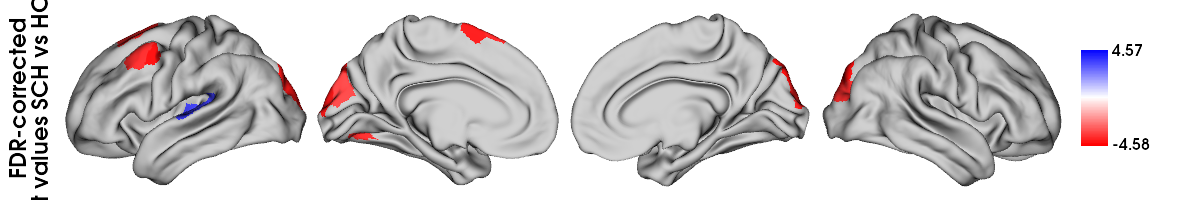

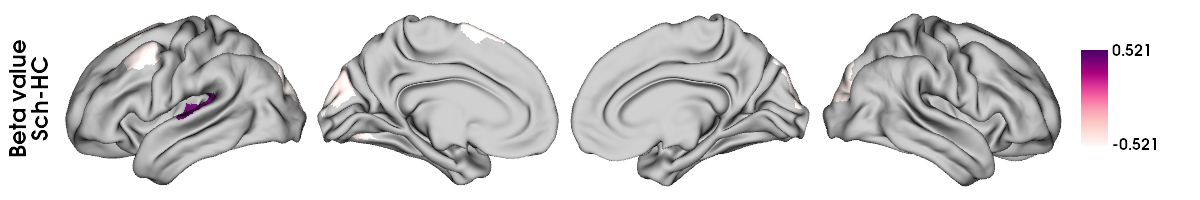

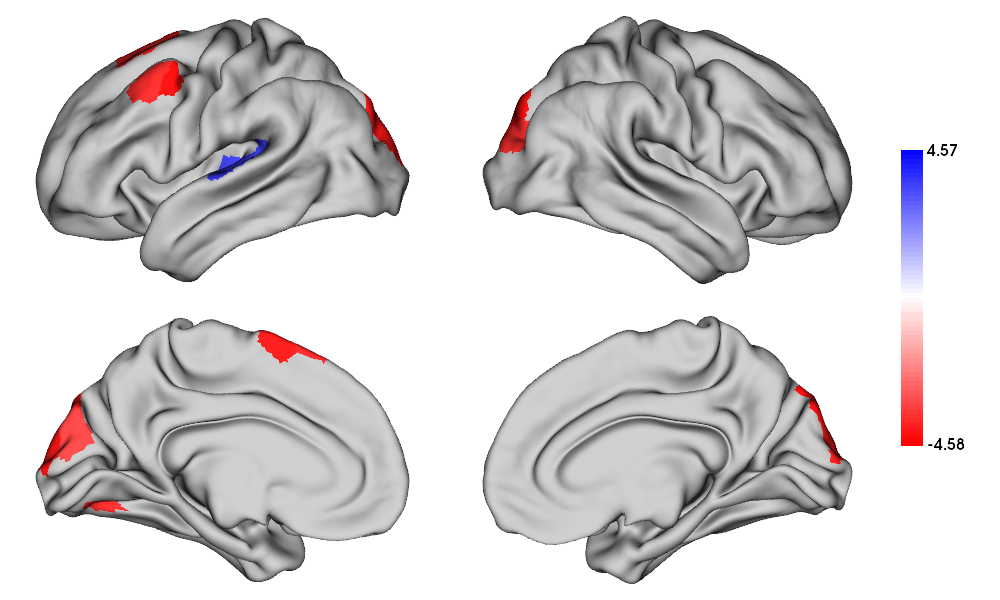

Number of significant parcels: 14

Number of significant parcels for sch: 3
Number of significant parcels for hc: 11

Number of significant parcels in each Yeo network (across group):
- visual: 7 out of 61 (11.48%) -> 50.0% of overall significance
- sensory motor: 3 out of 77 (3.9%) -> 21.43% of overall significance
- DMN: 4 out of 46 (8.7%) -> 28.57% of overall significance





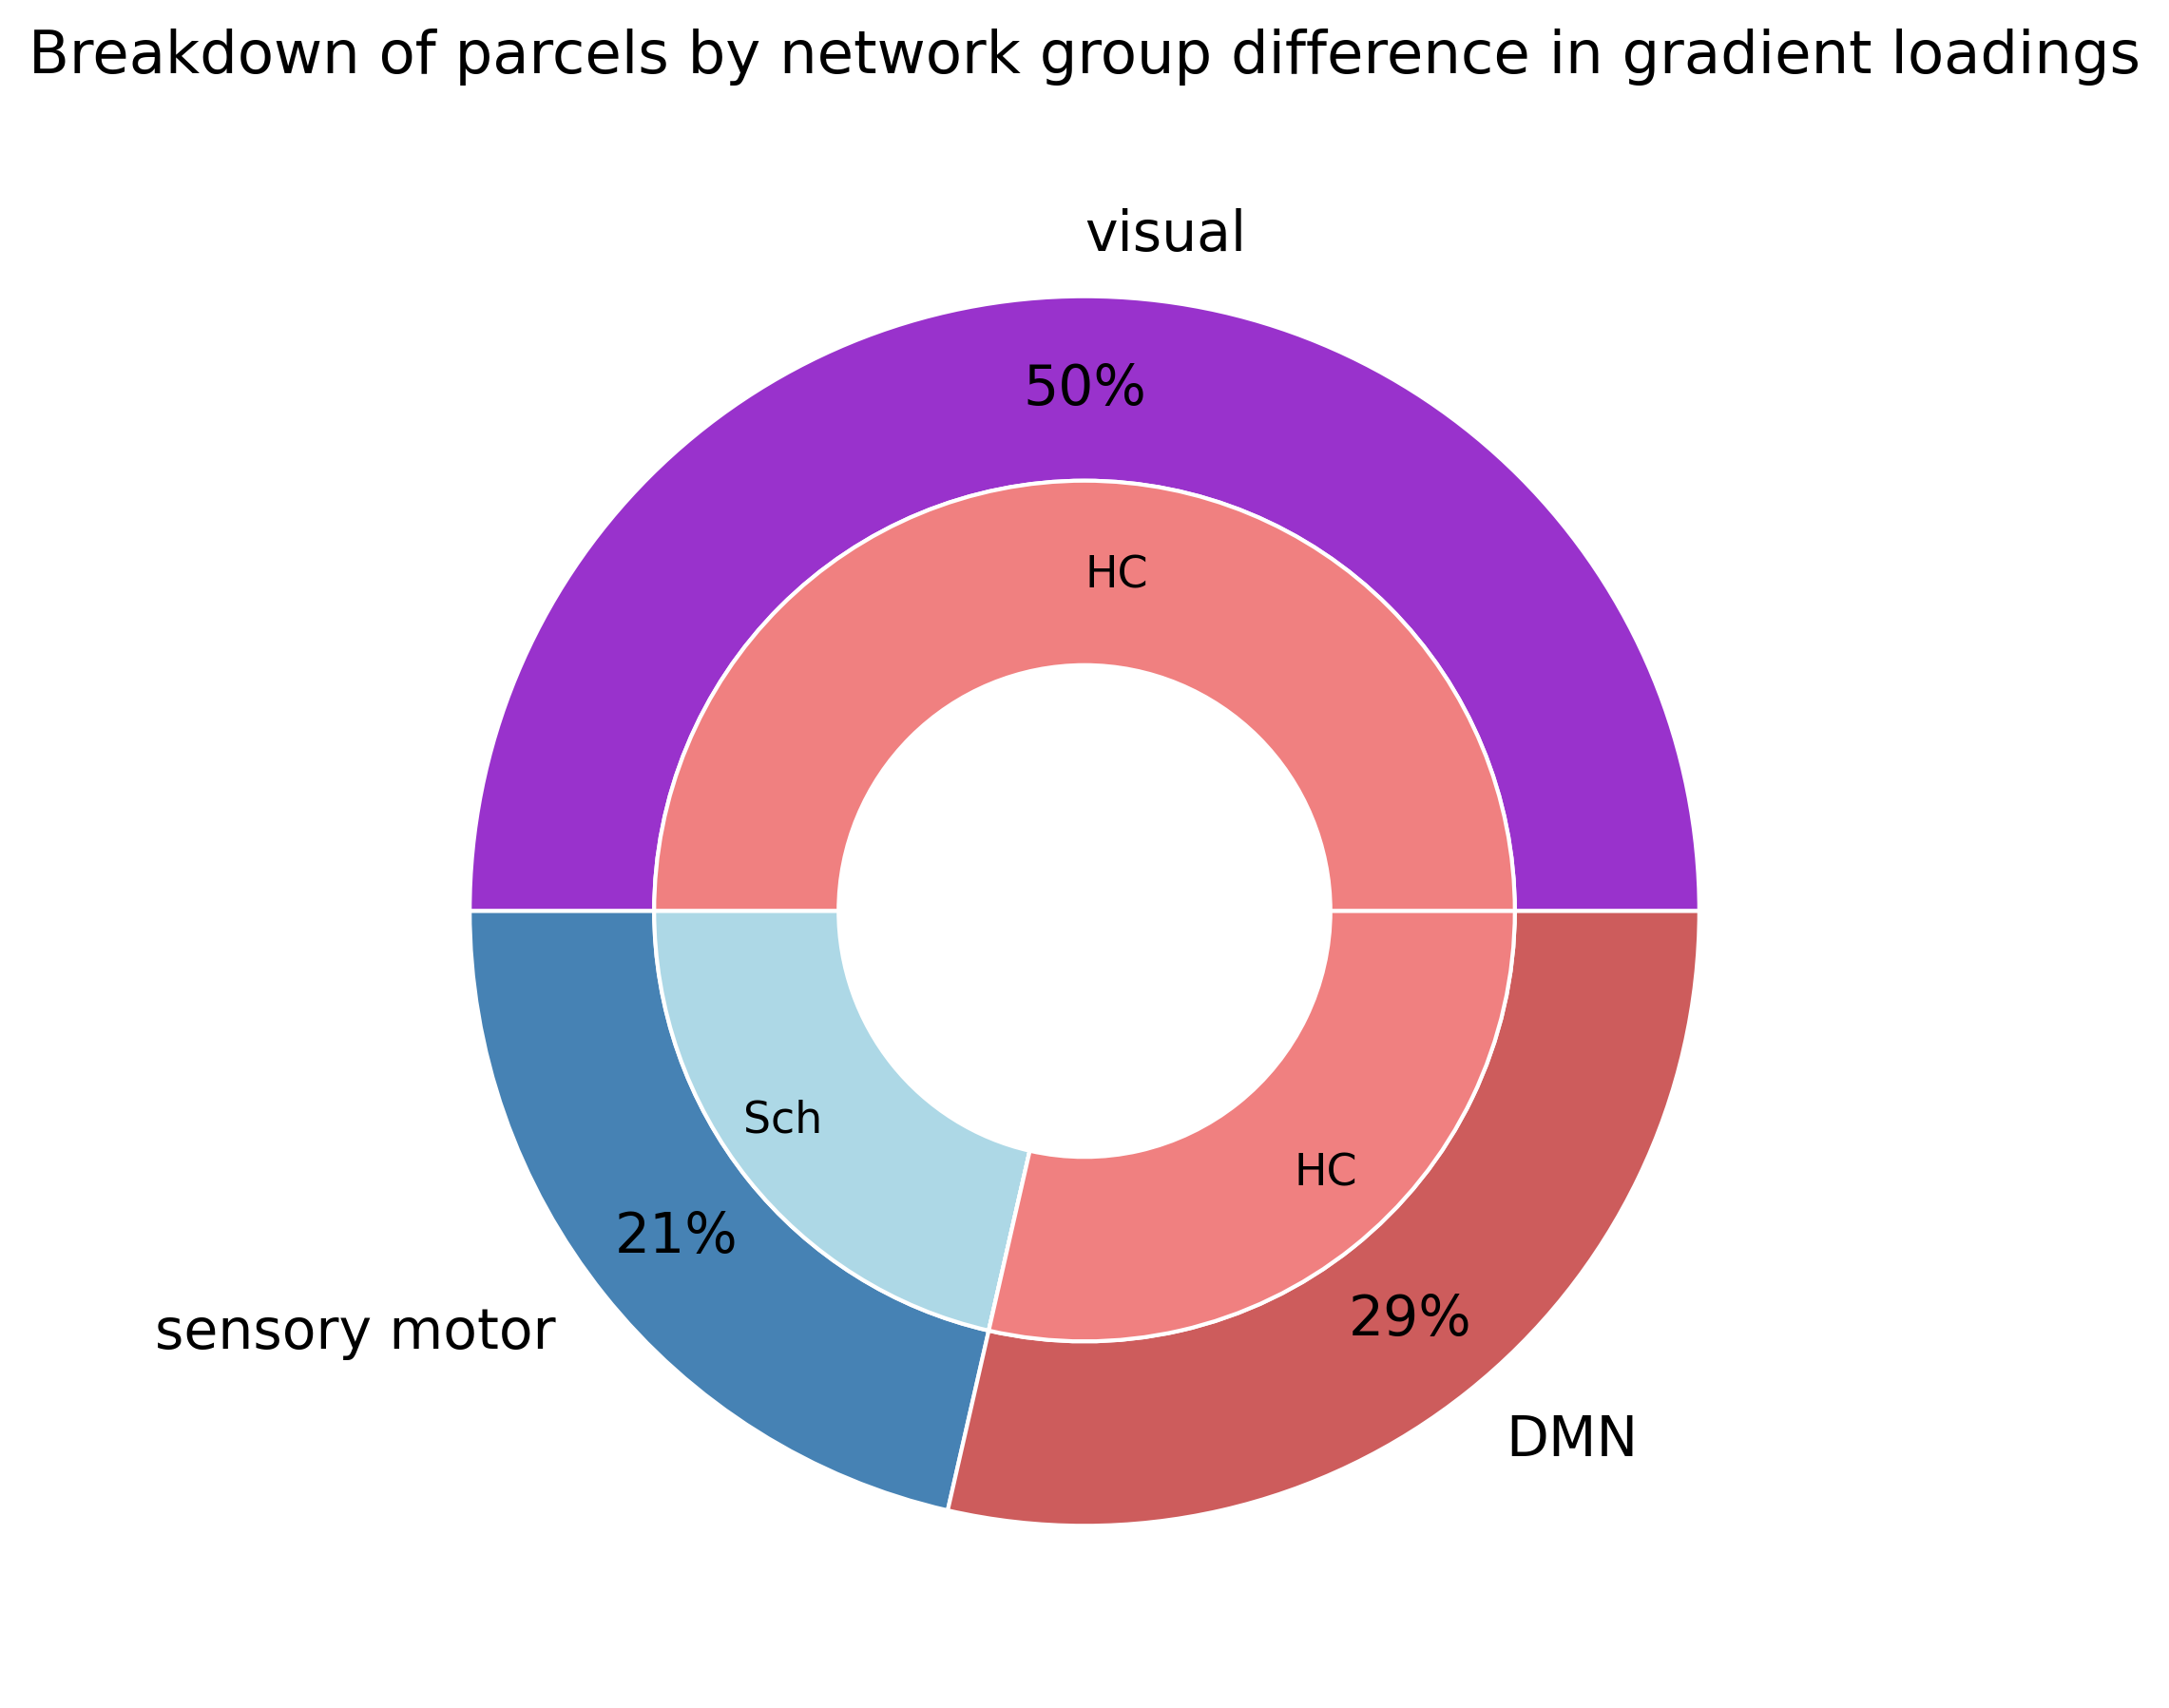

Number of significant parcels by sex:
visual - Sch: 0, HC: 7
sensory motor - Sch: 3, HC: 0
DMN - Sch: 0, HC: 4
dorsal attention - Sch: 0, HC: 0
ventral attention - Sch: 0, HC: 0
limbic - Sch: 0, HC: 0
fronto parietal - Sch: 0, HC: 0





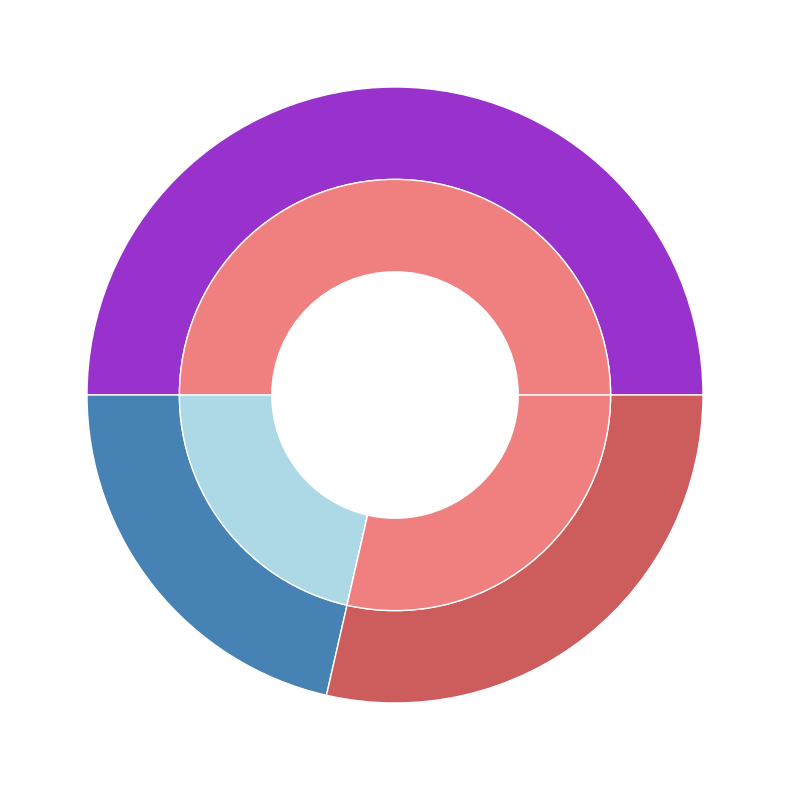

In [42]:
# GLM for G1
aligned_fc_G1 = np.load(f'/media/garlicseed/data2/Schizophrenia/FG_train/aligned_fc_G1.npy')
run_mixed_effects_analysis(aligned_fc_G1, modality='TOPO', label='G1')

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.011	 R^2_adj: -0.001

Log-likelihood: -469.304 	 AIC: 948.607	 BIC: 967.633

Fixed effects:

已完成 0/400 个parcel的分析
Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.013	 R^2_adj: 0.001

Log-likelihood: -468.874 	 AIC: 947.747	 BIC: 966.773

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.017	 R^2_adj: 0.005

Log-likelihood: -468.278 	 AIC: 946.557	 BIC: 965.583

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: paramet

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.008	 R^2_adj: -0.005

Log-likelihood: -469.821 	 AIC: 949.642	 BIC: 968.667

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.021	 R^2_adj: 0.009

Log-likelihood: -467.508 	 AIC: 945.015	 BIC: 964.041

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.022	 R^2_adj: 0.010

Log-likelihood: -467.473 	 AIC: 944.946	 BIC: 963.972

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.008	 R^2_adj: -0.004

Log-likelihood: -469.682 	 AIC: 949.364	 BIC: 968.389

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.010	 R^2_adj: -0.002

Log-likelihood: -469.456 	 AIC: 948.913	 BIC: 967.939

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.018	 R^2_adj: 0.006

Log-likelihood: -468.095 	 AIC: 946.190	 BIC: 965.216

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obse

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.016	 R^2_adj: 0.004

Log-likelihood: -468.396 	 AIC: 946.791	 BIC: 965.817

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.027	 R^2_adj: 0.015

Log-likelihood: -466.626 	 AIC: 943.252	 BIC: 962.277

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.001	 R^2_adj: -0.011

Log-likelihood: -470.930 	 AIC: 951.861	 BIC: 970.886

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.007	 R^2_adj: -0.005

Log-likelihood: -469.861 	 AIC: 949.722	 BIC: 968.747

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.037	 R^2_adj: 0.025

Log-likelihood: -464.826 	 AIC: 939.652	 BIC: 958.678

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.020	 R^2_adj: 0.008

Log-likelihood: -467.708 	 AIC: 945.416	 BIC: 964.442

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.025	 R^2_adj: 0.013

Log-likelihood: -466.892 	 AIC: 943.784	 BIC: 962.810

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.053	 R^2_adj: 0.041

Log-likelihood: -462.035 	 AIC: 934.069	 BIC: 953.095

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.054	 R^2_adj: 0.042

Log-likelihood: -461.862 	 AIC: 933.724	 BIC: 952.750

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.019	 R^2_adj: 0.007

Log-likelihood: -467.953 	 AIC: 945.905	 BIC: 964.931

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.005	 R^2_adj: -0.007

Log-likelihood: -470.268 	 AIC: 950.535	 BIC: 969.561

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.053	 R^2_adj: 0.042

Log-likelihood: -462.016 	 AIC: 934.032	 BIC: 953.057

Fixed effects:

已完成 250/400 个parcel的分析
Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: param

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.001	 R^2_adj: -0.011

Log-likelihood: -470.921 	 AIC: 951.841	 BIC: 970.867

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.018	 R^2_adj: 0.006

Log-likelihood: -468.095 	 AIC: 946.191	 BIC: 965.216

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.014	 R^2_adj: 0.002

Log-likelihood: -468.707 	 AIC: 947.413	 BIC: 966.439

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.024	 R^2_adj: 0.012

Log-likelihood: -467.086 	 AIC: 944.172	 BIC: 963.198

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.045	 R^2_adj: 0.034

Log-likelihood: -463.377 	 AIC: 936.755	 BIC: 955.780

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.065	 R^2_adj: 0.054

Log-likelihood: -459.939 	 AIC: 929.879	 BIC: 948.905

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.003	 R^2_adj: -0.009

Log-likelihood: -470.512 	 AIC: 951.025	 BIC: 970.050

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.041	 R^2_adj: 0.030

Log-likelihood: -464.063 	 AIC: 938.126	 BIC: 957.151

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.005	 R^2_adj: -0.007

Log-likelihood: -470.219 	 AIC: 950.437	 BIC: 969.463

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obse

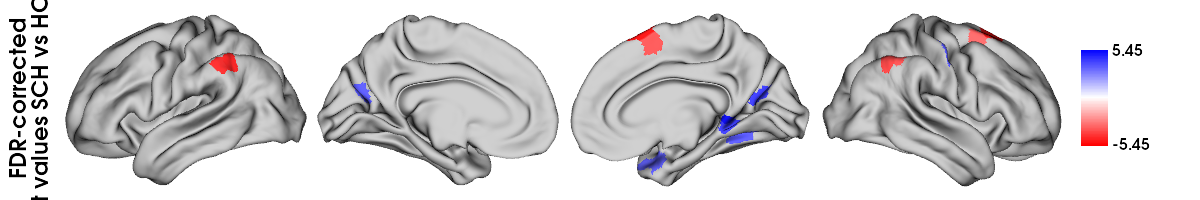

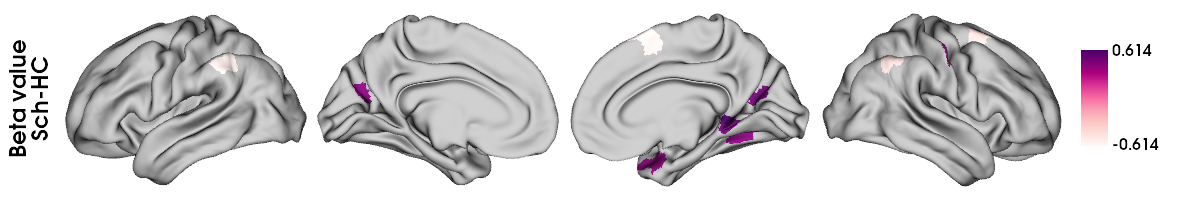

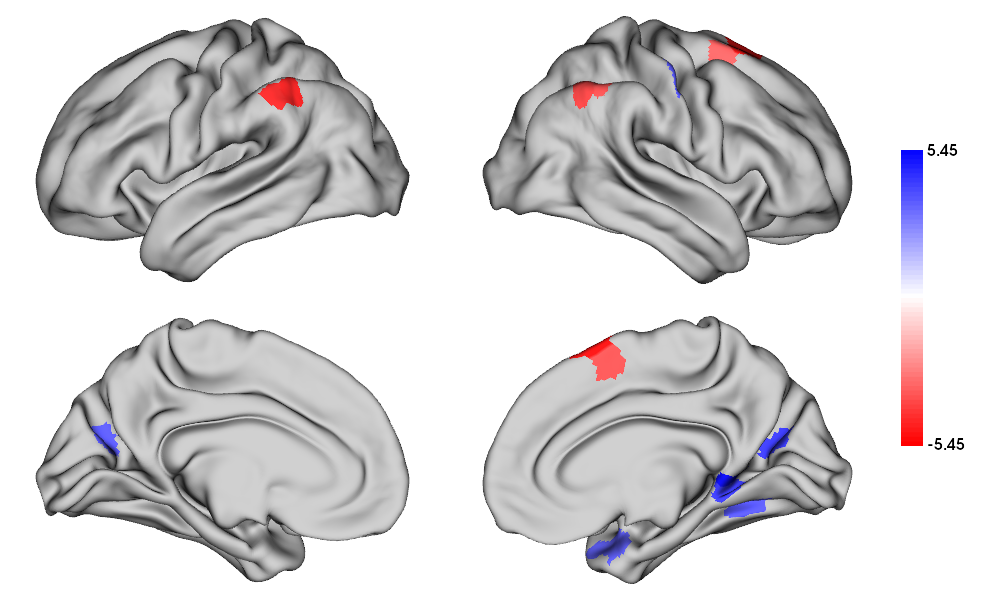

Number of significant parcels: 17

Number of significant parcels for sch: 7
Number of significant parcels for hc: 10

Number of significant parcels in each Yeo network (across group):
- visual: 5 out of 61 (8.2%) -> 29.41% of overall significance
- sensory motor: 1 out of 77 (1.3%) -> 5.88% of overall significance
- DMN: 1 out of 46 (2.17%) -> 5.88% of overall significance
- ventral attention: 1 out of 26 (3.85%) -> 5.88% of overall significance
- limbic: 1 out of 52 (1.92%) -> 5.88% of overall significance
- fronto parietal: 8 out of 91 (8.79%) -> 47.06% of overall significance





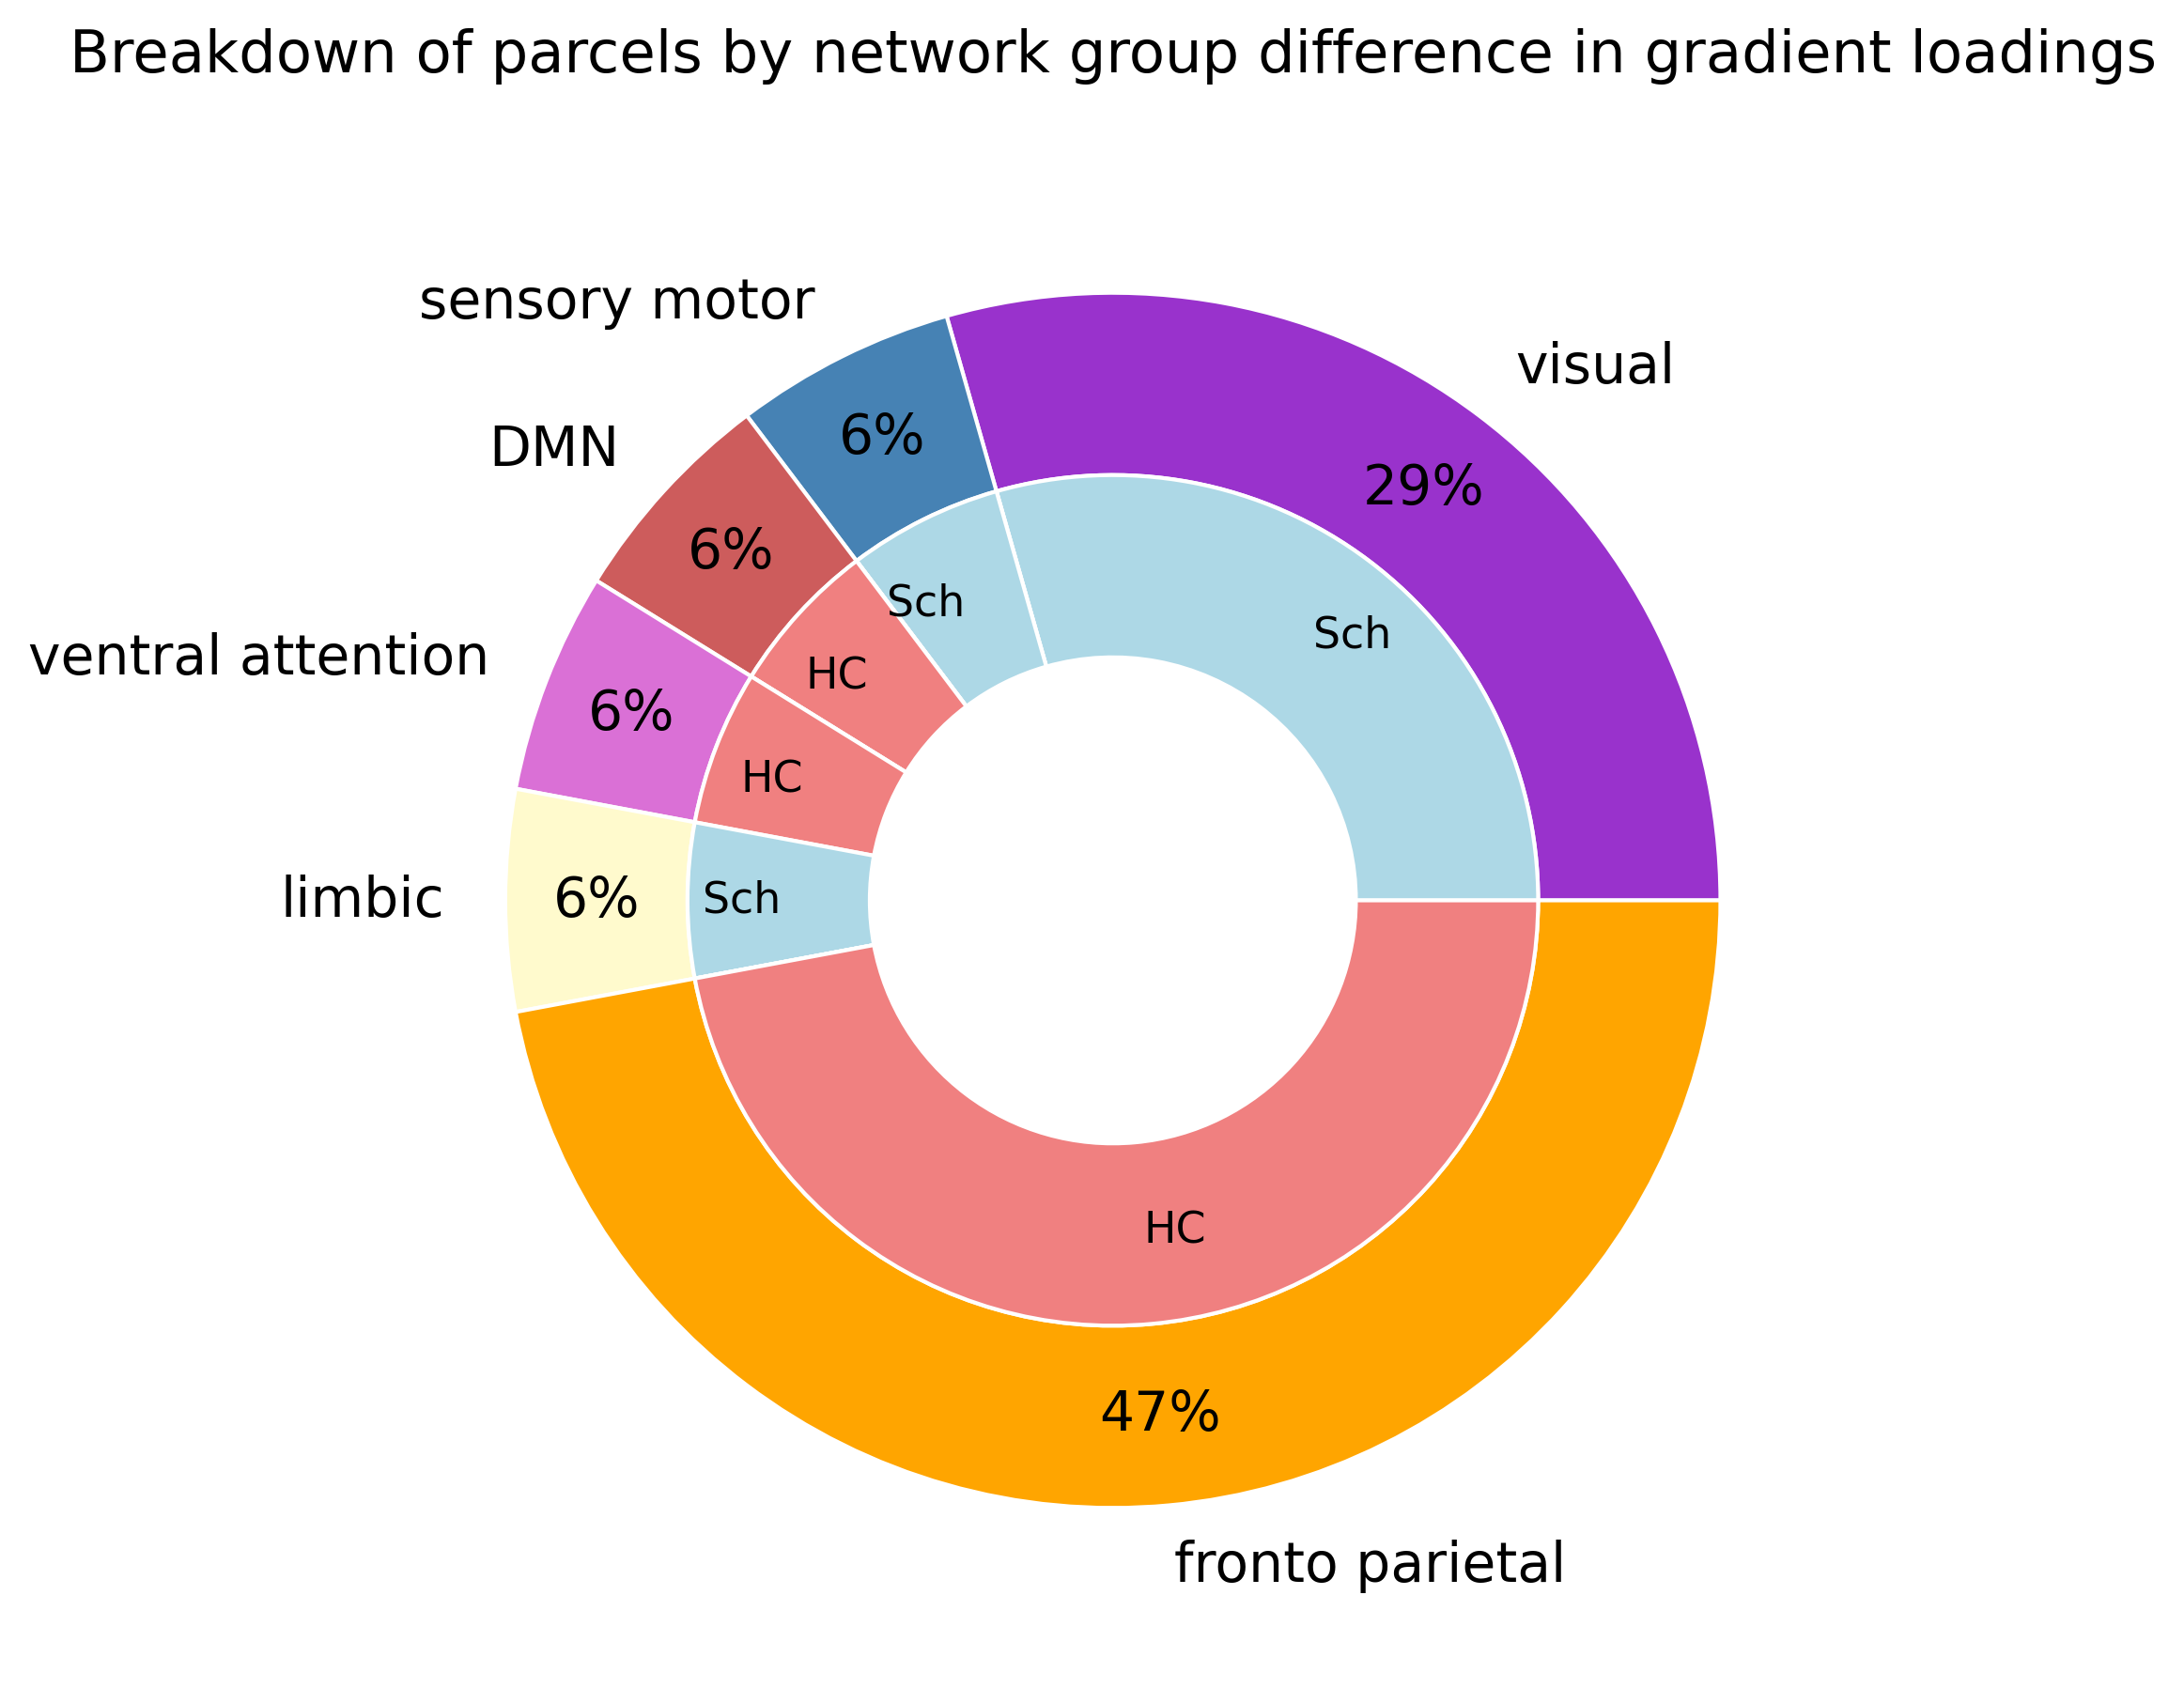

Number of significant parcels by sex:
visual - Sch: 5, HC: 0
sensory motor - Sch: 1, HC: 0
DMN - Sch: 0, HC: 1
dorsal attention - Sch: 0, HC: 0
ventral attention - Sch: 0, HC: 1
limbic - Sch: 1, HC: 0
fronto parietal - Sch: 0, HC: 8





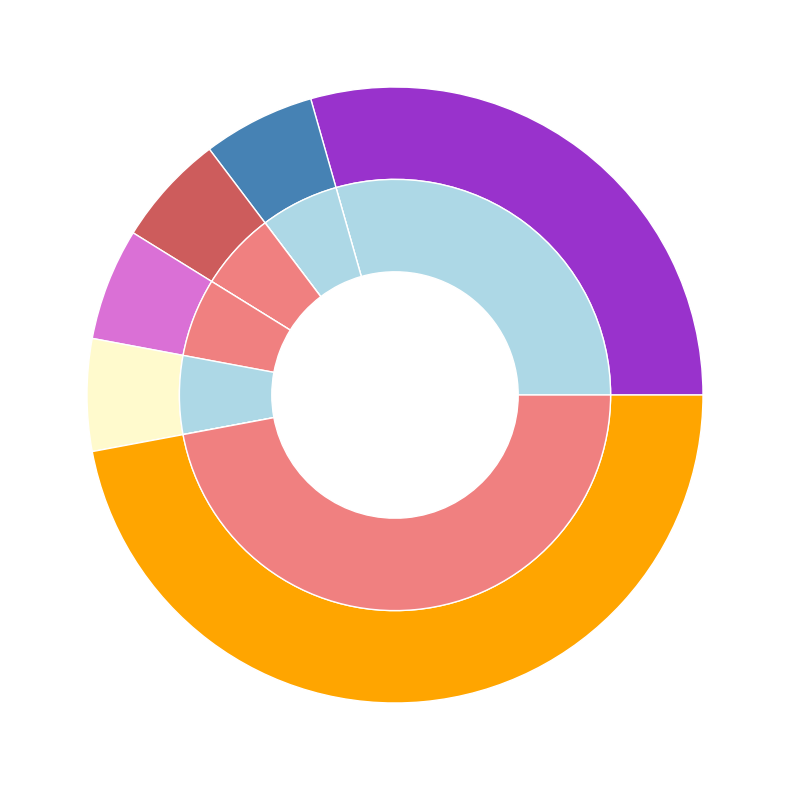

In [43]:
# GLM for G2
aligned_fc_G2 = np.load(f'/media/garlicseed/data2/Schizophrenia/FG_train/aligned_fc_G2.npy')
run_mixed_effects_analysis(aligned_fc_G2, modality='TOPO', label='G2')

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.019	 R^2_adj: 0.007

Log-likelihood: -467.886 	 AIC: 945.771	 BIC: 964.797

Fixed effects:

已完成 0/400 个parcel的分析
Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.024	 R^2_adj: 0.012

Log-likelihood: -467.067 	 AIC: 944.135	 BIC: 963.160

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.025	 R^2_adj: 0.013

Log-likelihood: -466.947 	 AIC: 943.893	 BIC: 962.919

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametr

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.015	 R^2_adj: 0.003

Log-likelihood: -468.512 	 AIC: 947.023	 BIC: 966.049

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.017	 R^2_adj: 0.005

Log-likelihood: -468.230 	 AIC: 946.460	 BIC: 965.486

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.022	 R^2_adj: 0.010

Log-likelihood: -467.445 	 AIC: 944.889	 BIC: 963.915

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.041	 R^2_adj: 0.029

Log-likelihood: -464.150 	 AIC: 938.301	 BIC: 957.326

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.010	 R^2_adj: -0.002

Log-likelihood: -469.399 	 AIC: 948.797	 BIC: 967.823

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.042	 R^2_adj: 0.030

Log-likelihood: -463.976 	 AIC: 937.952	 BIC: 956.978

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.015	 R^2_adj: 0.003

Log-likelihood: -468.531 	 AIC: 947.063	 BIC: 966.088

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.009	 R^2_adj: -0.003

Log-likelihood: -469.512 	 AIC: 949.024	 BIC: 968.050

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.022	 R^2_adj: 0.010

Log-likelihood: -467.357 	 AIC: 944.713	 BIC: 963.739

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.047	 R^2_adj: 0.035

Log-likelihood: -463.100 	 AIC: 936.201	 BIC: 955.226

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.061	 R^2_adj: 0.049

Log-likelihood: -460.677 	 AIC: 931.355	 BIC: 950.381

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.036	 R^2_adj: 0.024

Log-likelihood: -464.976 	 AIC: 939.953	 BIC: 958.979

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.006	 R^2_adj: -0.006

Log-likelihood: -470.140 	 AIC: 950.281	 BIC: 969.306

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.021	 R^2_adj: 0.009

Log-likelihood: -467.525 	 AIC: 945.050	 BIC: 964.076

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.005	 R^2_adj: -0.007

Log-likelihood: -470.175 	 AIC: 950.349	 BIC: 969.375

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obse

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.013	 R^2_adj: 0.001

Log-likelihood: -468.972 	 AIC: 947.944	 BIC: 966.970

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.005	 R^2_adj: -0.007

Log-likelihood: -470.270 	 AIC: 950.540	 BIC: 969.566

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.009	 R^2_adj: -0.003

Log-likelihood: -469.576 	 AIC: 949.153	 BIC: 968.178

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obse

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.021	 R^2_adj: 0.009

Log-likelihood: -467.632 	 AIC: 945.265	 BIC: 964.291

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.037	 R^2_adj: 0.025

Log-likelihood: -464.859 	 AIC: 939.717	 BIC: 958.743

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.030	 R^2_adj: 0.018

Log-likelihood: -466.106 	 AIC: 942.213	 BIC: 961.238

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.052	 R^2_adj: 0.040

Log-likelihood: -462.304 	 AIC: 934.608	 BIC: 953.634

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.005	 R^2_adj: -0.007

Log-likelihood: -470.275 	 AIC: 950.550	 BIC: 969.576

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.061	 R^2_adj: 0.050

Log-likelihood: -460.639 	 AIC: 931.278	 BIC: 950.304

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.019	 R^2_adj: 0.007

Log-likelihood: -467.942 	 AIC: 945.883	 BIC: 964.909

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.008	 R^2_adj: -0.005

Log-likelihood: -469.817 	 AIC: 949.635	 BIC: 968.660

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.040	 R^2_adj: 0.028

Log-likelihood: -464.356 	 AIC: 938.712	 BIC: 957.738

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

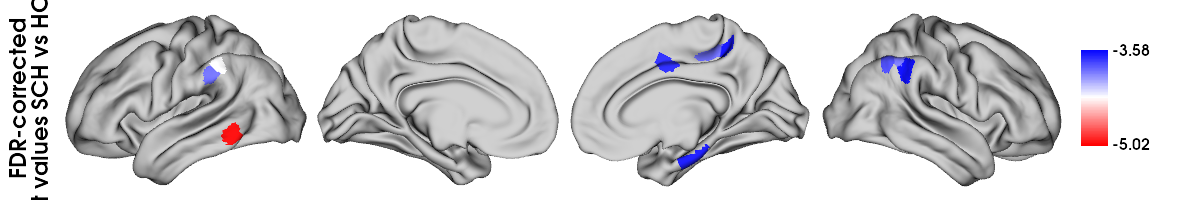

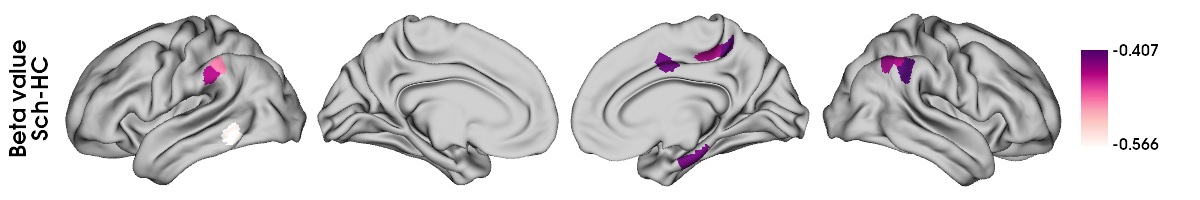

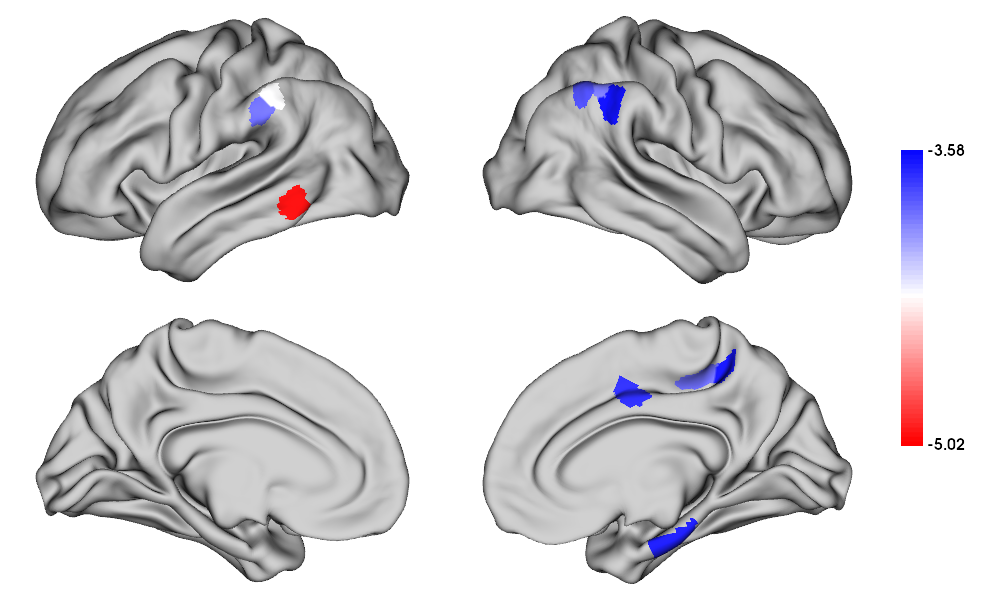

Number of significant parcels: 11

Number of significant parcels for sch: 0
Number of significant parcels for hc: 11

Number of significant parcels in each Yeo network (across group):
- ventral attention: 5 out of 26 (19.23%) -> 45.45% of overall significance
- limbic: 1 out of 52 (1.92%) -> 9.09% of overall significance
- fronto parietal: 5 out of 91 (5.49%) -> 45.45% of overall significance





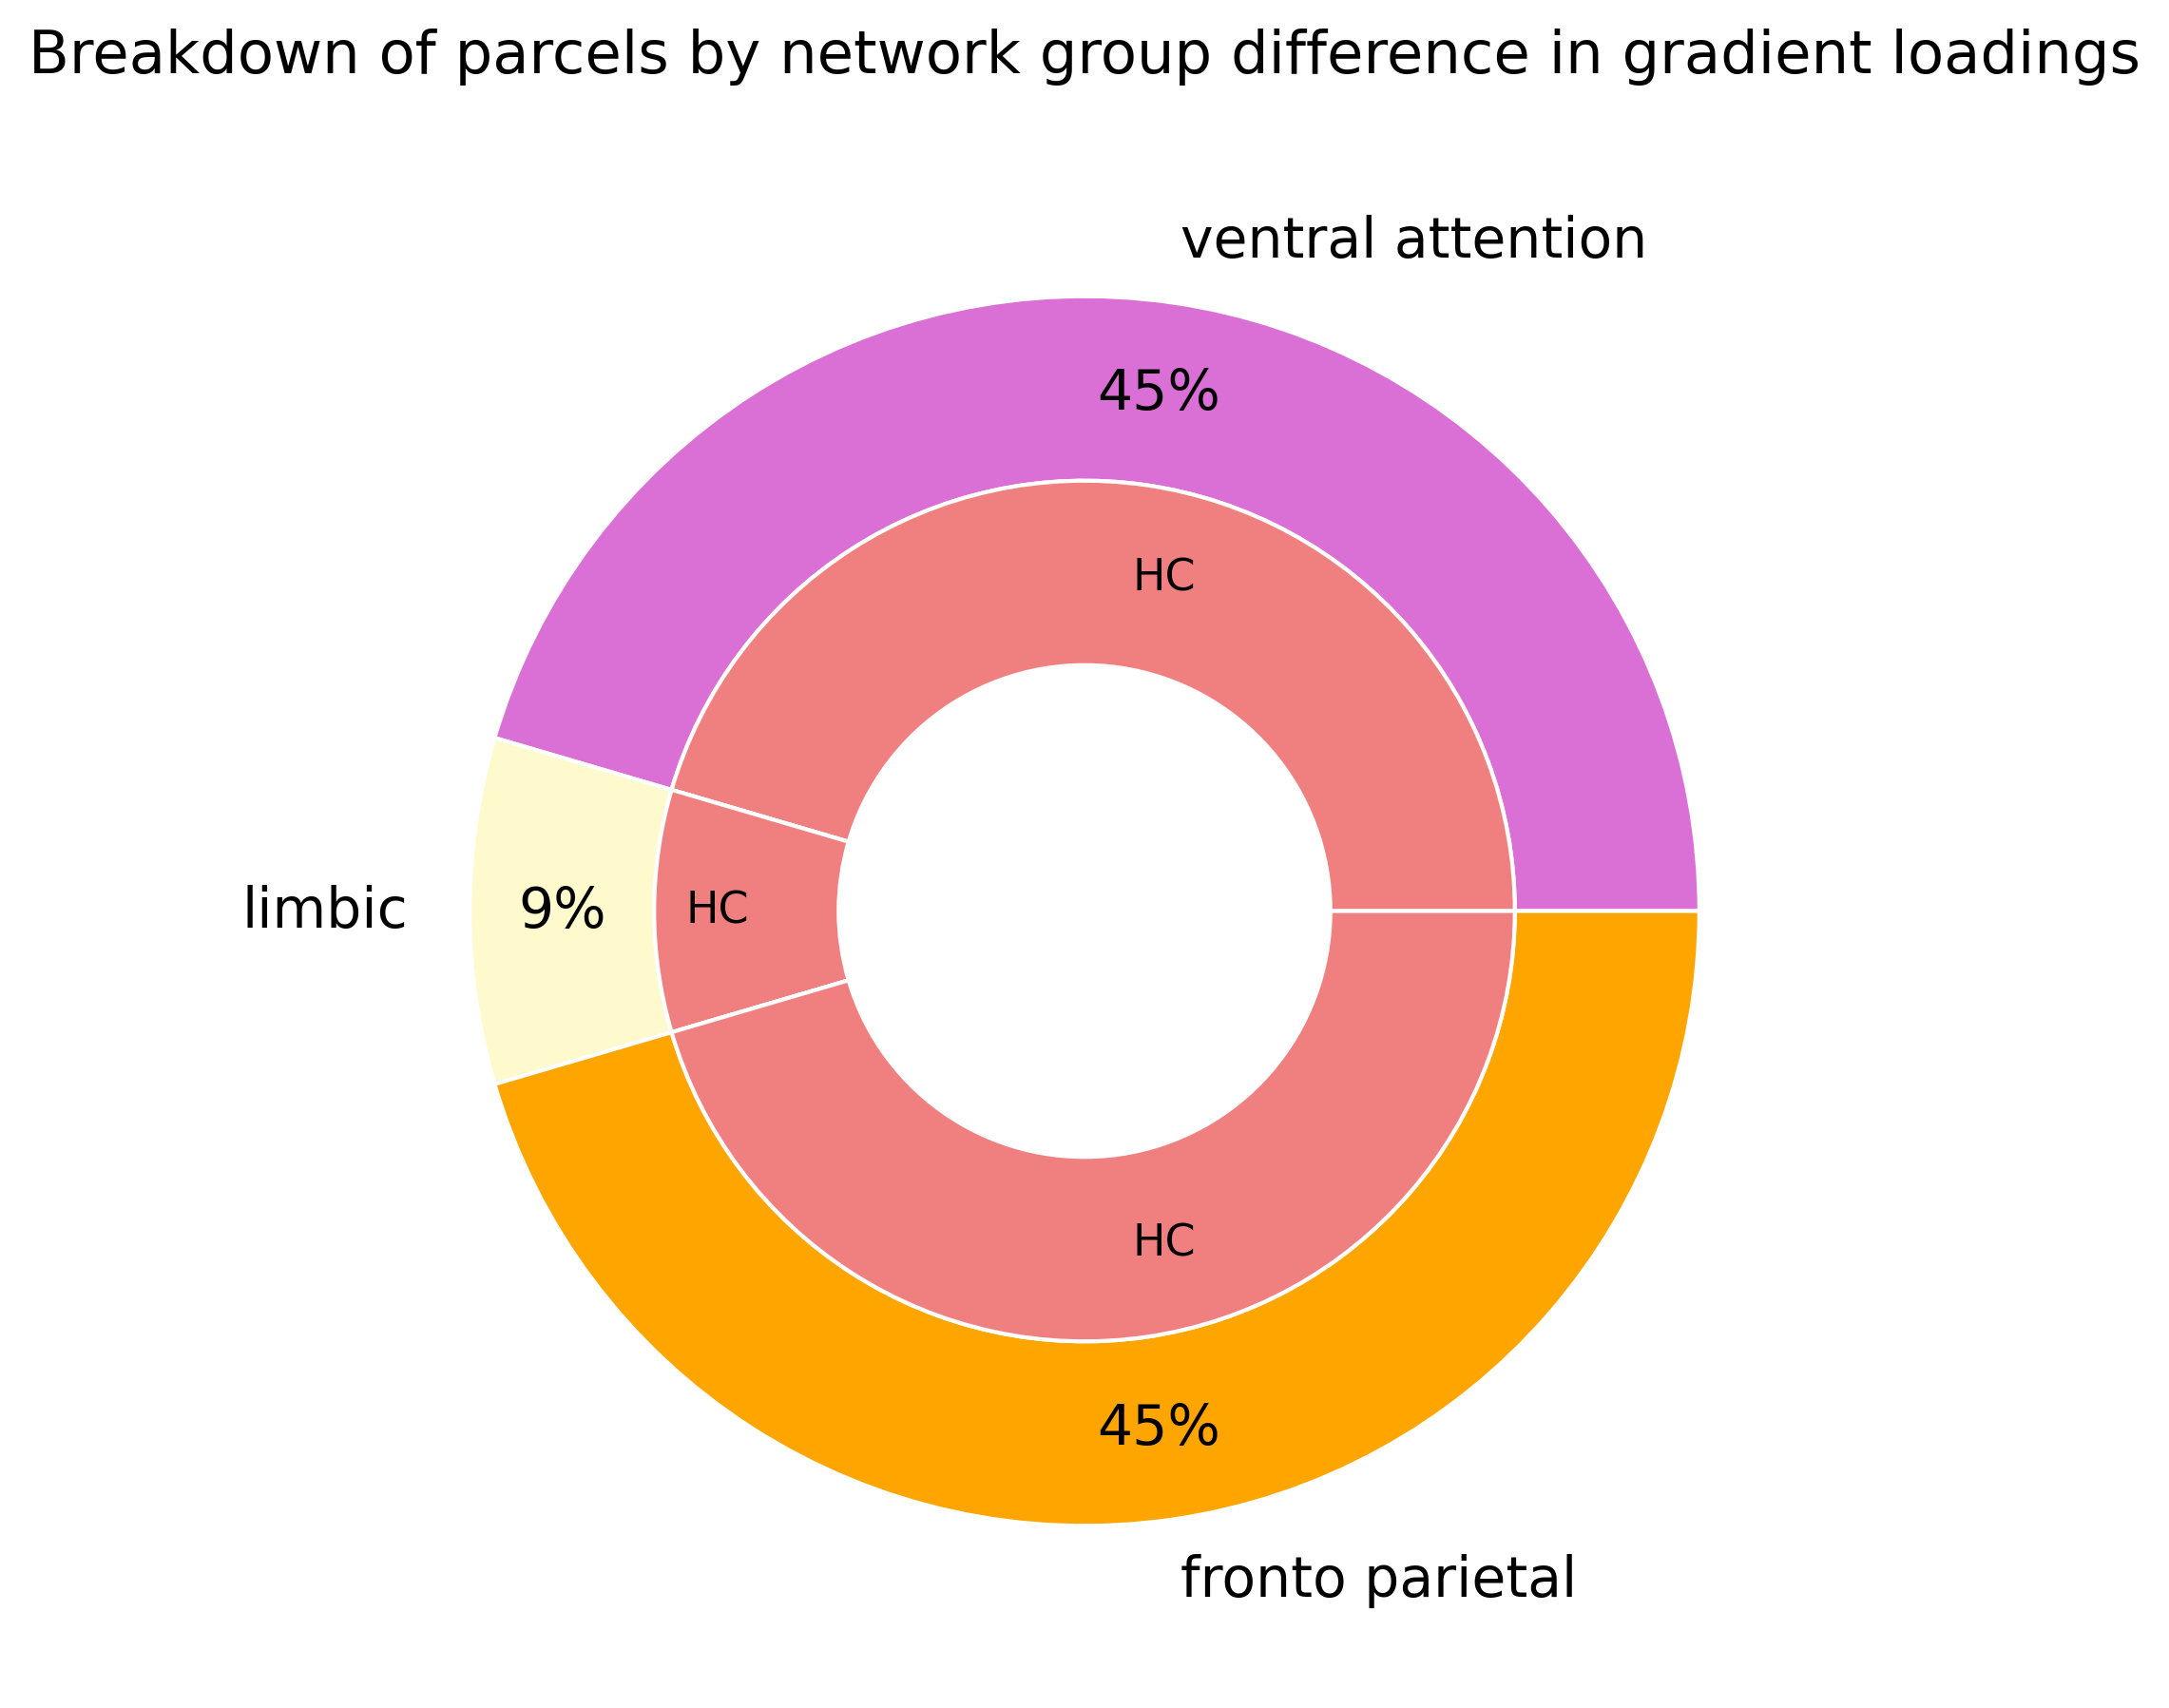

Number of significant parcels by sex:
visual - Sch: 0, HC: 0
sensory motor - Sch: 0, HC: 0
DMN - Sch: 0, HC: 0
dorsal attention - Sch: 0, HC: 0
ventral attention - Sch: 0, HC: 5
limbic - Sch: 0, HC: 1
fronto parietal - Sch: 0, HC: 5





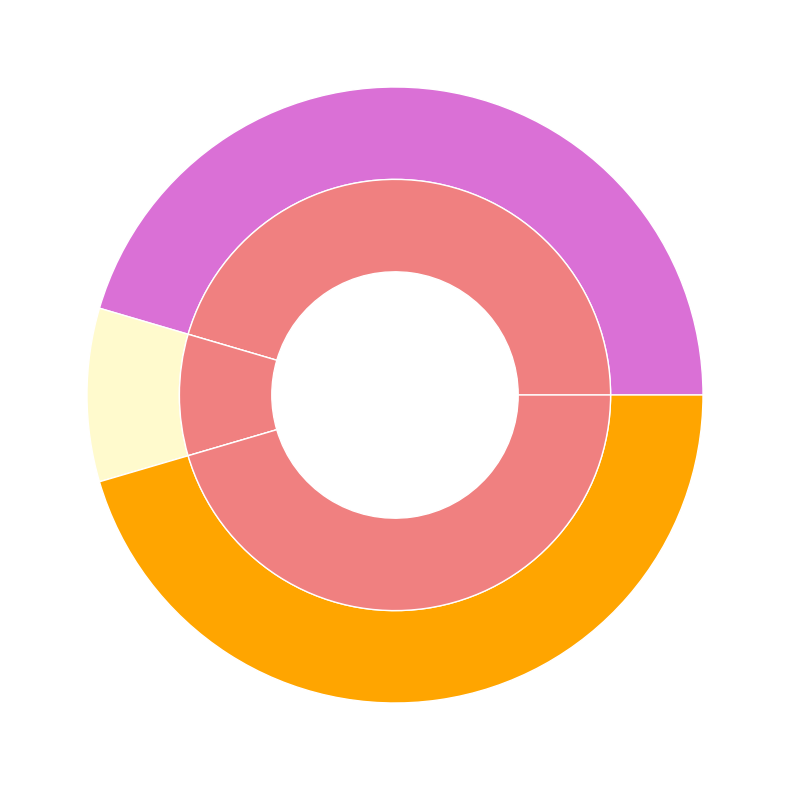

In [44]:
# GLM for Geodesic_distance
mean_geodesic_distances = pd.read_csv('/media/garlicseed/data2/Schizophrenia/GD_train/mean_geodesic_distances.csv',header=None)
schz_mask = df['diagnosis'] == 'SCHZ'
hc_mask = df['diagnosis'] == 'CONTROL'
mean_geodesic_distances_Sch = np.array(mean_geodesic_distances[schz_mask])
mean_geodesic_distances_HC = np.array(mean_geodesic_distances[hc_mask])
geodesic = np.concatenate([mean_geodesic_distances_Sch, mean_geodesic_distances_HC])
pd.DataFrame(geodesic).to_csv(f"/media/garlicseed/data2/Schizophrenia/morpho_train/combine_data/geodesic_SCHZ_HC.csv", index=False)
pd.DataFrame(mean_geodesic_distances_Sch).to_csv(f"/media/garlicseed/data2/Schizophrenia/morpho_train/combine_data/geodesic_SCHZ.csv", index=False)
run_mixed_effects_analysis(geodesic, modality='MORPH', label='Geodesic_distance')

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.083	 R^2_adj: 0.072

Log-likelihood: -456.718 	 AIC: 923.435	 BIC: 942.461

Fixed effects:

已完成 0/400 个parcel的分析
Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.038	 R^2_adj: 0.027

Log-likelihood: -464.581 	 AIC: 939.162	 BIC: 958.188

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.060	 R^2_adj: 0.049

Log-likelihood: -460.801 	 AIC: 931.602	 BIC: 950.628

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametr

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.046	 R^2_adj: 0.035

Log-likelihood: -463.200 	 AIC: 936.399	 BIC: 955.425

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.045	 R^2_adj: 0.033

Log-likelihood: -463.473 	 AIC: 936.945	 BIC: 955.971

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.044	 R^2_adj: 0.032

Log-likelihood: -463.620 	 AIC: 937.241	 BIC: 956.266

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.039	 R^2_adj: 0.027

Log-likelihood: -464.457 	 AIC: 938.914	 BIC: 957.940

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.049	 R^2_adj: 0.037

Log-likelihood: -462.810 	 AIC: 935.619	 BIC: 954.645

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.009	 R^2_adj: -0.003

Log-likelihood: -469.539 	 AIC: 949.078	 BIC: 968.104

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.065	 R^2_adj: 0.054

Log-likelihood: -459.895 	 AIC: 929.789	 BIC: 948.815

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.079	 R^2_adj: 0.068

Log-likelihood: -457.425 	 AIC: 924.849	 BIC: 943.875

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.090	 R^2_adj: 0.079

Log-likelihood: -455.416 	 AIC: 920.832	 BIC: 939.858

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.028	 R^2_adj: 0.016

Log-likelihood: -466.364 	 AIC: 942.727	 BIC: 961.753

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.045	 R^2_adj: 0.034

Log-likelihood: -463.404 	 AIC: 936.807	 BIC: 955.833

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.069	 R^2_adj: 0.057

Log-likelihood: -459.246 	 AIC: 928.493	 BIC: 947.519

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.112	 R^2_adj: 0.101

Log-likelihood: -451.454 	 AIC: 912.908	 BIC: 931.934

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.074	 R^2_adj: 0.062

Log-likelihood: -458.374 	 AIC: 926.748	 BIC: 945.773

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.066	 R^2_adj: 0.055

Log-likelihood: -459.751 	 AIC: 929.502	 BIC: 948.528

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.095	 R^2_adj: 0.084

Log-likelihood: -454.481 	 AIC: 918.961	 BIC: 937.987

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.032	 R^2_adj: 0.020

Log-likelihood: -465.740 	 AIC: 941.480	 BIC: 960.506

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.036	 R^2_adj: 0.025

Log-likelihood: -464.927 	 AIC: 939.855	 BIC: 958.881

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.023	 R^2_adj: 0.011

Log-likelihood: -467.253 	 AIC: 944.506	 BIC: 963.531

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.028	 R^2_adj: 0.016

Log-likelihood: -466.411 	 AIC: 942.823	 BIC: 961.849

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.024	 R^2_adj: 0.012

Log-likelihood: -467.098 	 AIC: 944.196	 BIC: 963.221

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.081	 R^2_adj: 0.069

Log-likelihood: -457.117 	 AIC: 924.234	 BIC: 943.260

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.065	 R^2_adj: 0.054

Log-likelihood: -459.873 	 AIC: 929.746	 BIC: 948.772

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.084	 R^2_adj: 0.073

Log-likelihood: -456.574 	 AIC: 923.148	 BIC: 942.174

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.079	 R^2_adj: 0.068

Log-likelihood: -457.393 	 AIC: 924.785	 BIC: 943.811

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.063	 R^2_adj: 0.052

Log-likelihood: -460.230 	 AIC: 930.461	 BIC: 949.486

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.085	 R^2_adj: 0.074

Log-likelihood: -456.347 	 AIC: 922.694	 BIC: 941.720

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

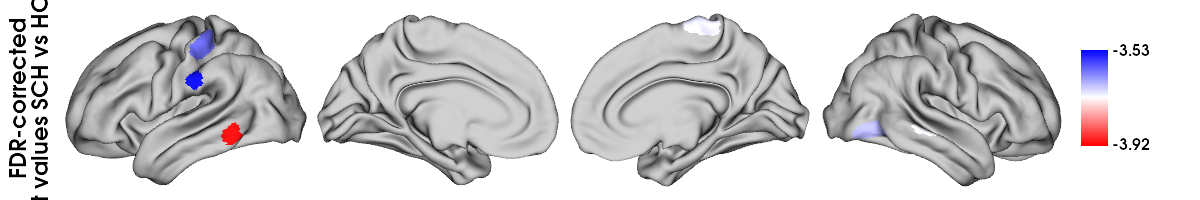

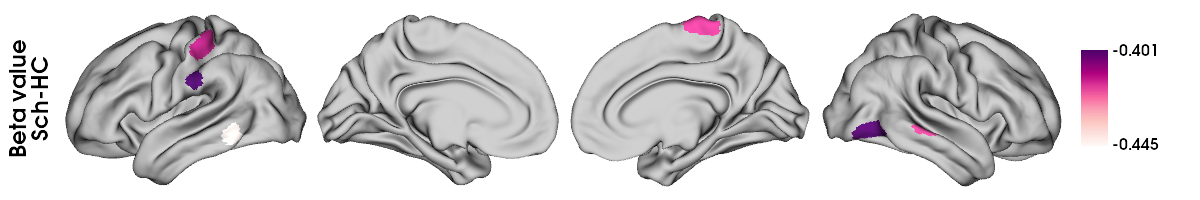

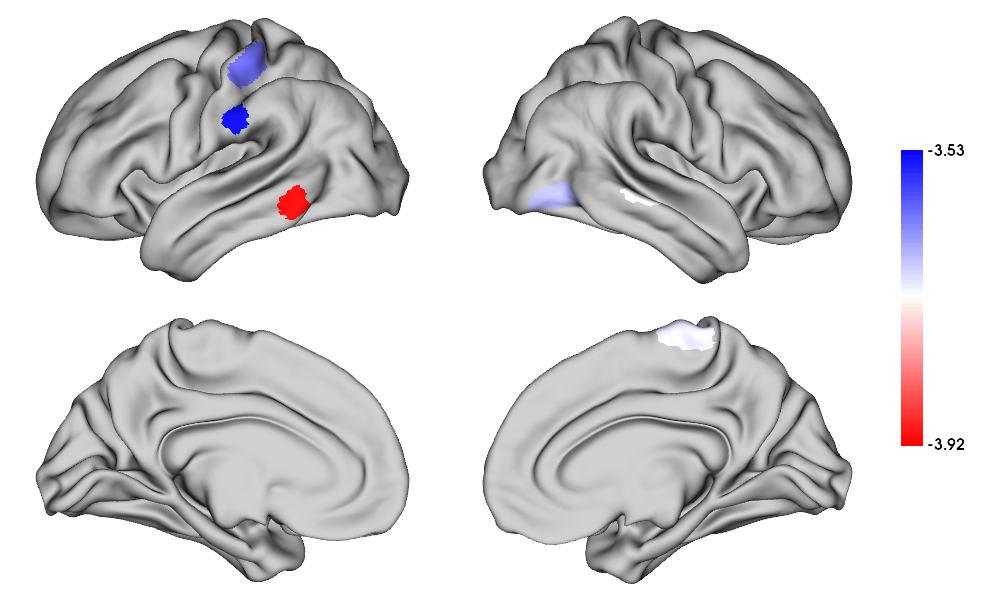

Number of significant parcels: 6

Number of significant parcels for sch: 0
Number of significant parcels for hc: 6

Number of significant parcels in each Yeo network (across group):
- visual: 1 out of 61 (1.64%) -> 16.67% of overall significance
- sensory motor: 2 out of 77 (2.6%) -> 33.33% of overall significance
- DMN: 1 out of 46 (2.17%) -> 16.67% of overall significance
- ventral attention: 1 out of 26 (3.85%) -> 16.67% of overall significance
- fronto parietal: 1 out of 91 (1.1%) -> 16.67% of overall significance





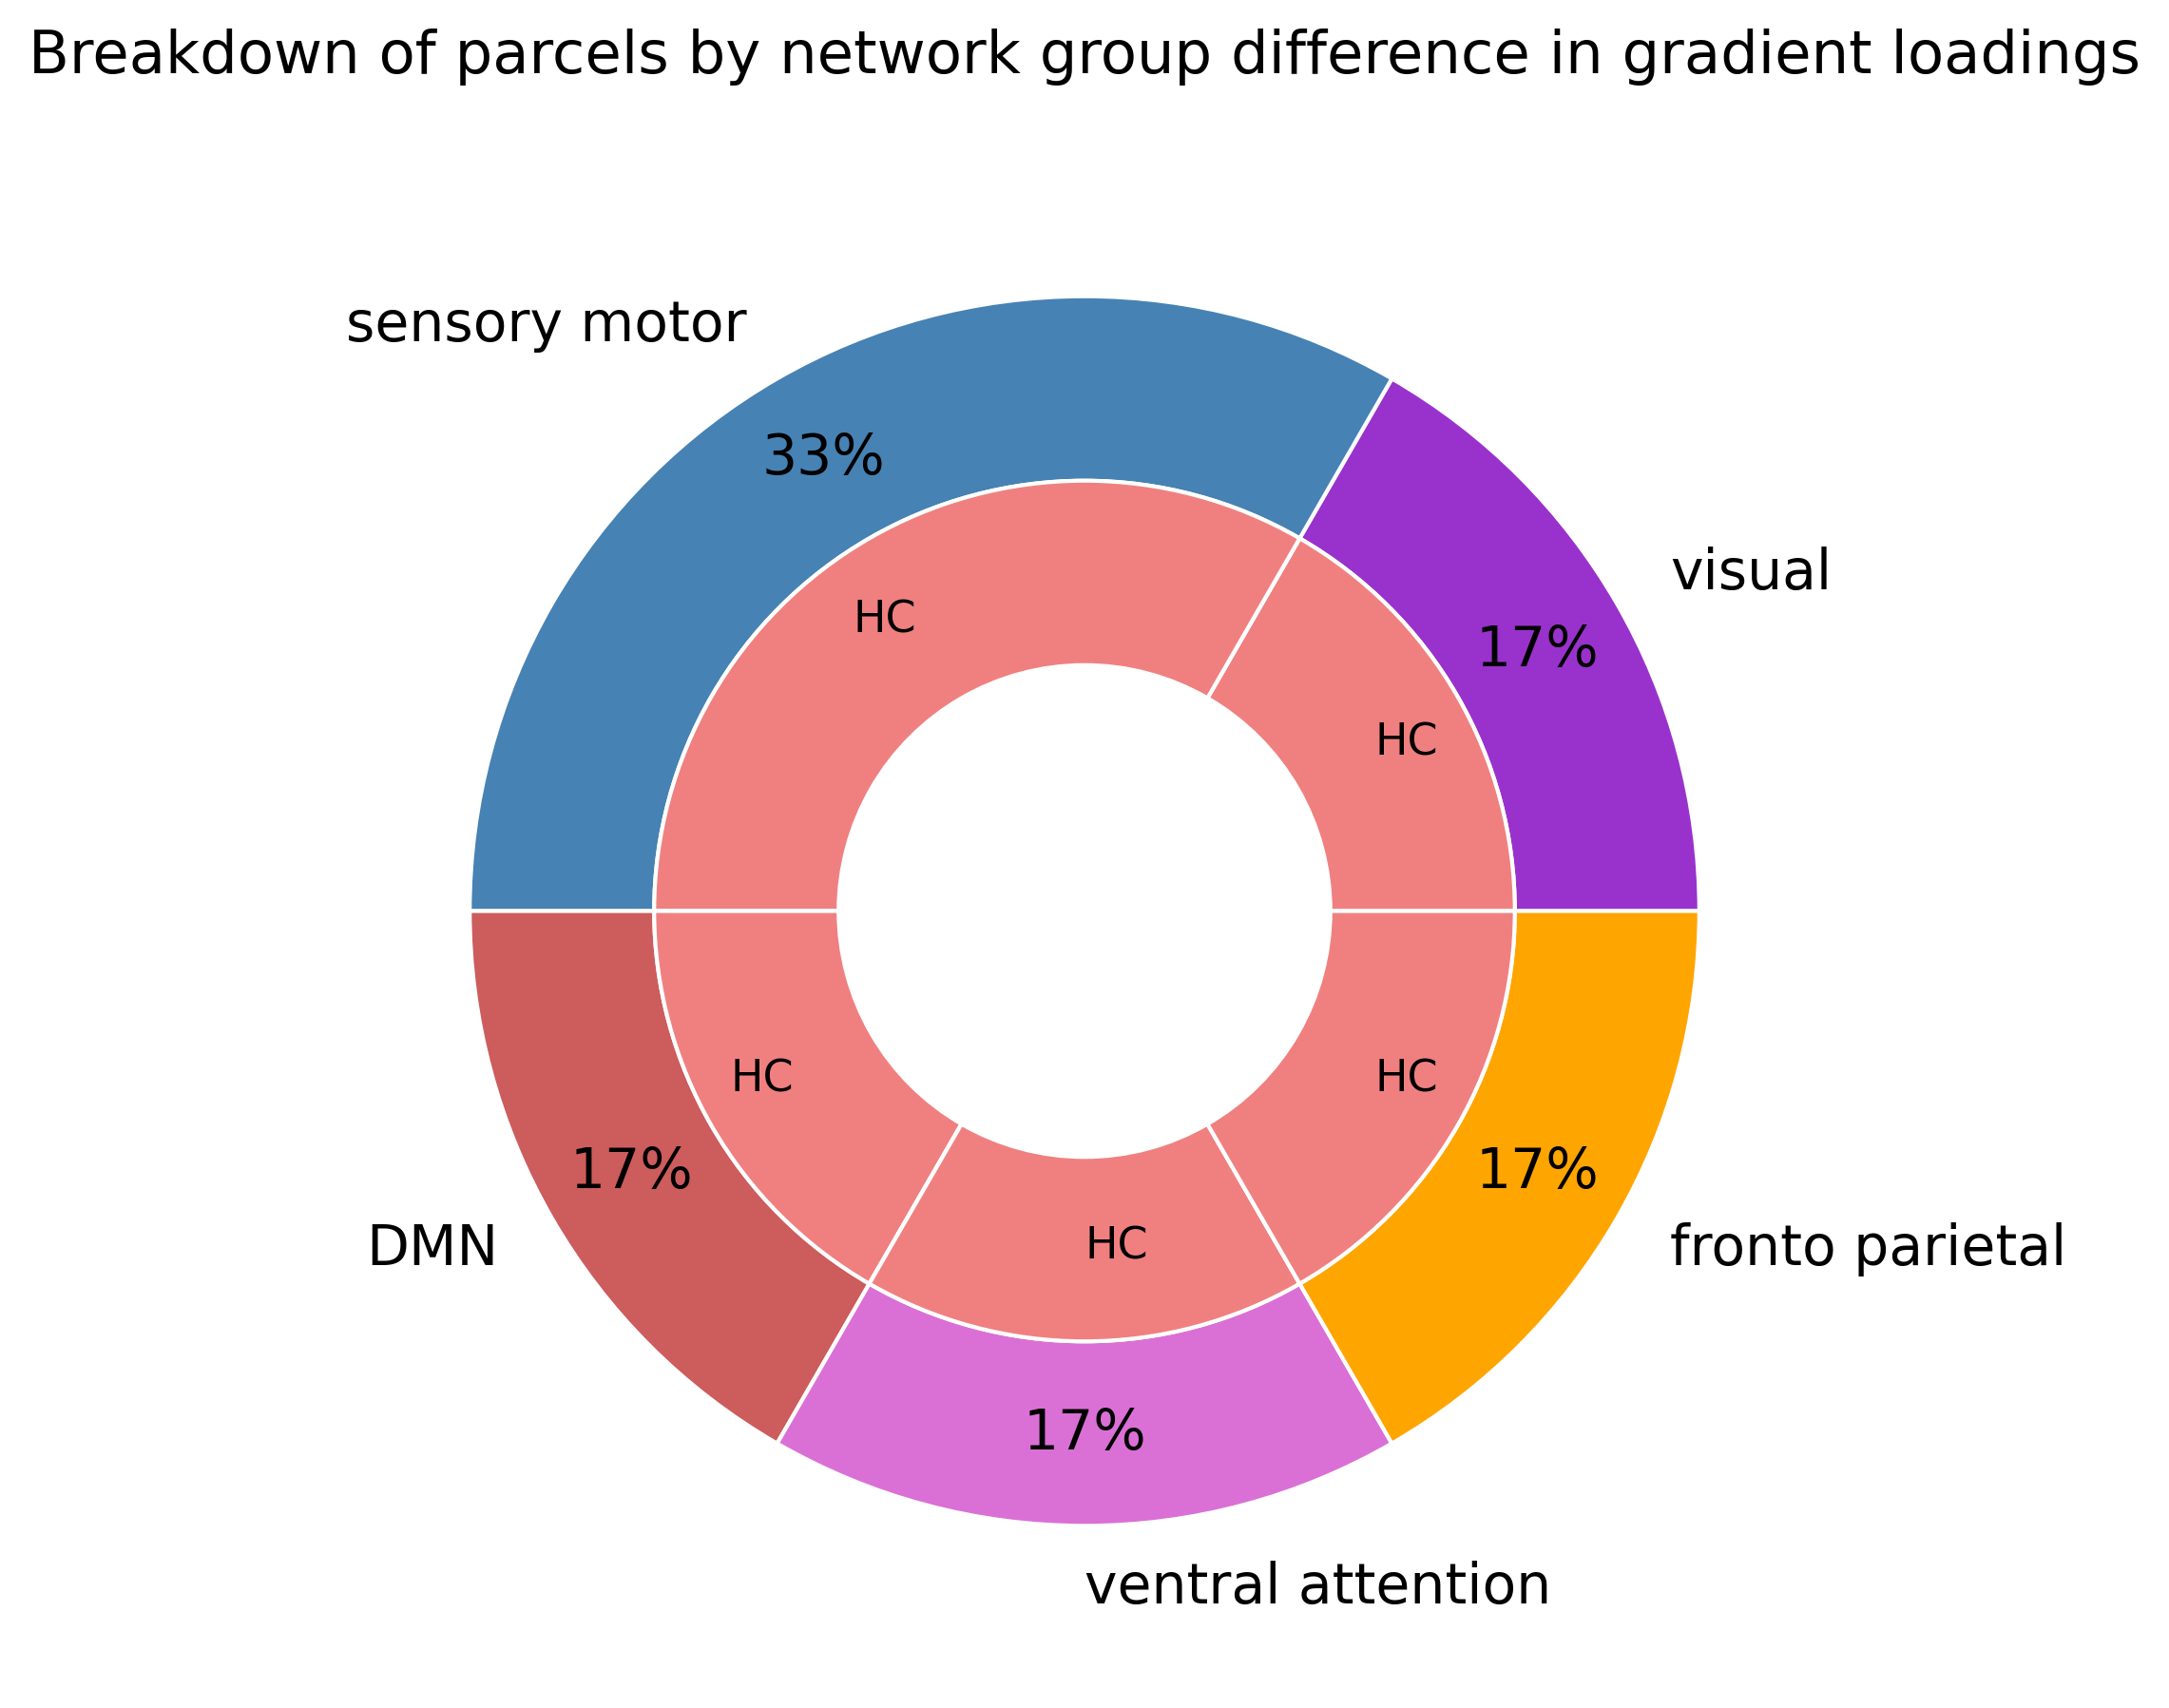

Number of significant parcels by sex:
visual - Sch: 0, HC: 1
sensory motor - Sch: 0, HC: 2
DMN - Sch: 0, HC: 1
dorsal attention - Sch: 0, HC: 0
ventral attention - Sch: 0, HC: 1
limbic - Sch: 0, HC: 0
fronto parietal - Sch: 0, HC: 1





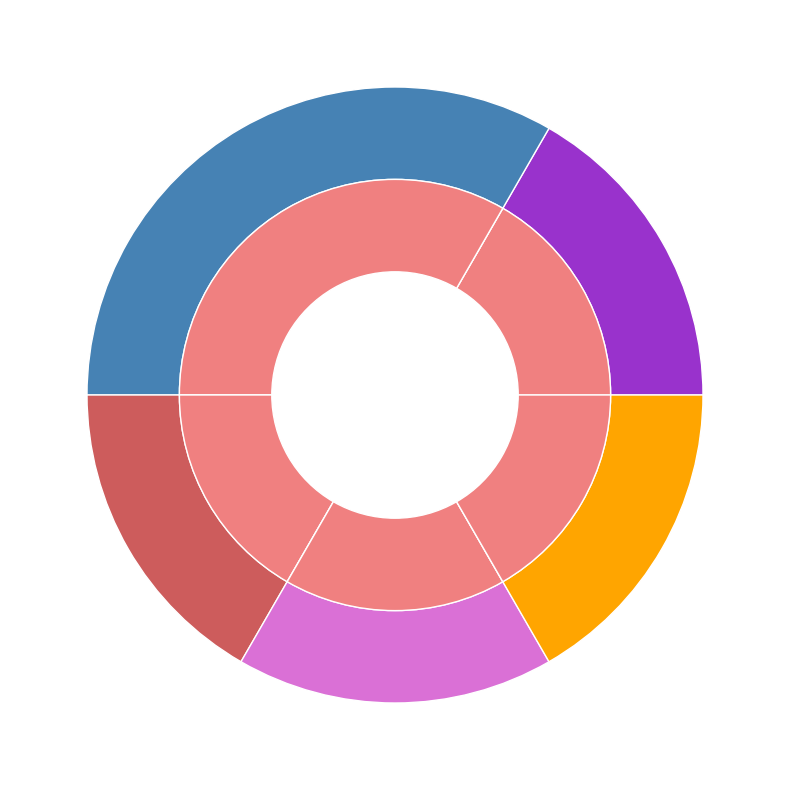

In [45]:
# GLM for GrayVolume
GrayVolume = pd.read_csv('/media/garlicseed/data2/Schizophrenia/morpho_train/combine_data/GV_stack_SCHZ_HC.csv')
run_mixed_effects_analysis(GrayVolume, modality='MORPH', label='GV')

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.032	 R^2_adj: 0.020

Log-likelihood: -465.662 	 AIC: 941.323	 BIC: 960.349

Fixed effects:

已完成 0/400 个parcel的分析
Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.053	 R^2_adj: 0.041

Log-likelihood: -462.039 	 AIC: 934.078	 BIC: 953.103

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.064	 R^2_adj: 0.052

Log-likelihood: -460.193 	 AIC: 930.385	 BIC: 949.411

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametr

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.023	 R^2_adj: 0.011

Log-likelihood: -467.270 	 AIC: 944.540	 BIC: 963.565

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.051	 R^2_adj: 0.040

Log-likelihood: -462.353 	 AIC: 934.707	 BIC: 953.732

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.017	 R^2_adj: 0.005

Log-likelihood: -468.179 	 AIC: 946.358	 BIC: 965.384

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.056	 R^2_adj: 0.044

Log-likelihood: -461.530 	 AIC: 933.061	 BIC: 952.086

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.009	 R^2_adj: -0.003

Log-likelihood: -469.556 	 AIC: 949.112	 BIC: 968.138

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.040	 R^2_adj: 0.028

Log-likelihood: -464.376 	 AIC: 938.751	 BIC: 957.777

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.041	 R^2_adj: 0.029

Log-likelihood: -464.143 	 AIC: 938.286	 BIC: 957.312

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.033	 R^2_adj: 0.021

Log-likelihood: -465.560 	 AIC: 941.119	 BIC: 960.145

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.025	 R^2_adj: 0.013

Log-likelihood: -466.922 	 AIC: 943.843	 BIC: 962.869

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.065	 R^2_adj: 0.054

Log-likelihood: -459.861 	 AIC: 929.723	 BIC: 948.749

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.015	 R^2_adj: 0.003

Log-likelihood: -468.652 	 AIC: 947.303	 BIC: 966.329

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.065	 R^2_adj: 0.053

Log-likelihood: -460.008 	 AIC: 930.016	 BIC: 949.042

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.129	 R^2_adj: 0.118

Log-likelihood: -448.182 	 AIC: 906.365	 BIC: 925.390

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.110	 R^2_adj: 0.099

Log-likelihood: -451.791 	 AIC: 913.583	 BIC: 932.608

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.311	 R^2_adj: 0.303

Log-likelihood: -409.218 	 AIC: 828.437	 BIC: 847.463

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.044	 R^2_adj: 0.032

Log-likelihood: -463.683 	 AIC: 937.367	 BIC: 956.392

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.035	 R^2_adj: 0.023

Log-likelihood: -465.255 	 AIC: 940.510	 BIC: 959.535

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.044	 R^2_adj: 0.033

Log-likelihood: -463.579 	 AIC: 937.158	 BIC: 956.183

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.042	 R^2_adj: 0.030

Log-likelihood: -464.005 	 AIC: 938.010	 BIC: 957.036

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.043	 R^2_adj: 0.031

Log-likelihood: -463.813 	 AIC: 937.626	 BIC: 956.652

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.038	 R^2_adj: 0.026

Log-likelihood: -464.742 	 AIC: 939.483	 BIC: 958.509

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.023	 R^2_adj: 0.011

Log-likelihood: -467.246 	 AIC: 944.492	 BIC: 963.517

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.034	 R^2_adj: 0.022

Log-likelihood: -465.302 	 AIC: 940.605	 BIC: 959.631

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.046	 R^2_adj: 0.034

Log-likelihood: -463.295 	 AIC: 936.589	 BIC: 955.615

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.059	 R^2_adj: 0.048

Log-likelihood: -460.955 	 AIC: 931.909	 BIC: 950.935

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.037	 R^2_adj: 0.025

Log-likelihood: -464.854 	 AIC: 939.708	 BIC: 958.734

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.092	 R^2_adj: 0.080

Log-likelihood: -455.157 	 AIC: 920.313	 BIC: 939.339

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

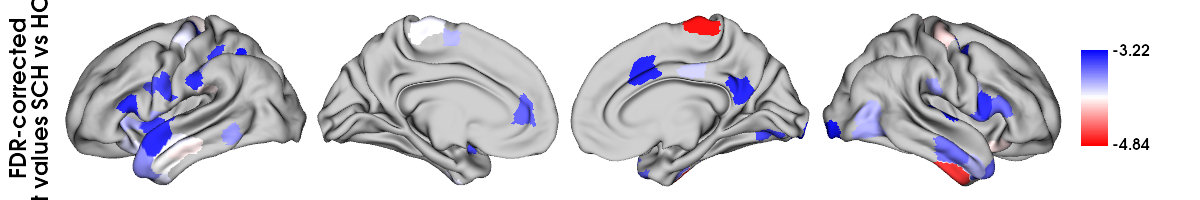

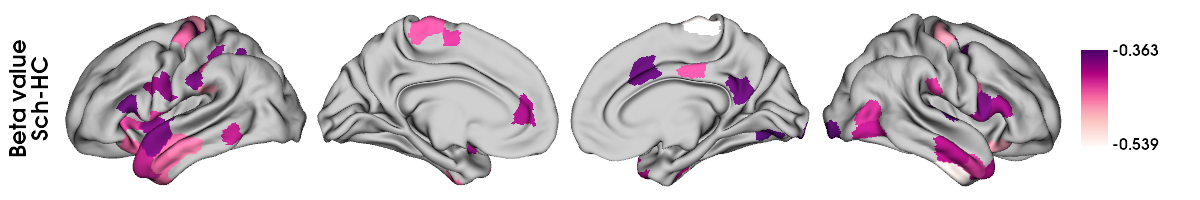

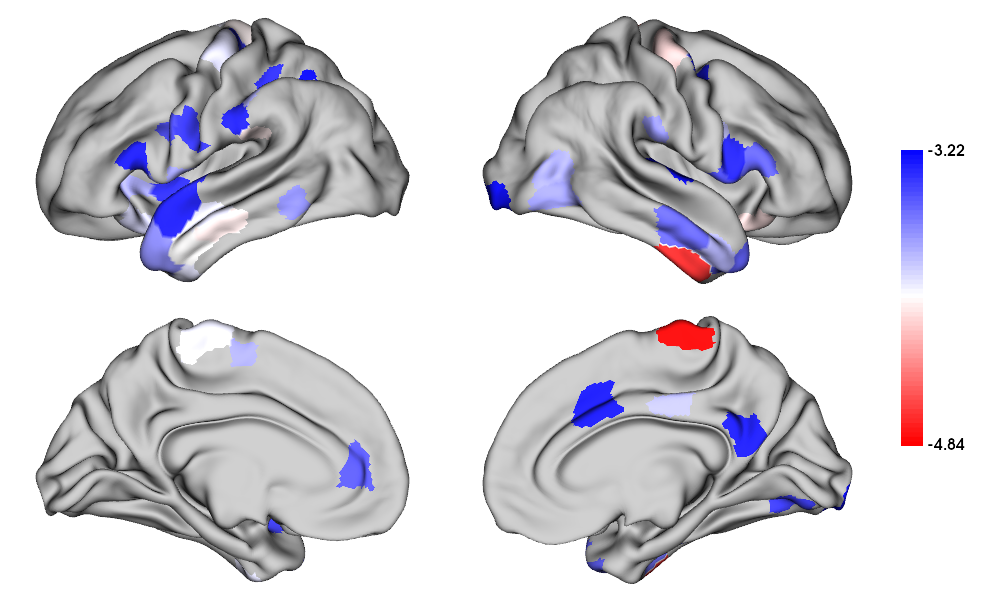

Number of significant parcels: 52

Number of significant parcels for sch: 0
Number of significant parcels for hc: 52

Number of significant parcels in each Yeo network (across group):
- visual: 4 out of 61 (6.56%) -> 7.69% of overall significance
- sensory motor: 10 out of 77 (12.99%) -> 19.23% of overall significance
- DMN: 13 out of 46 (28.26%) -> 25.0% of overall significance
- dorsal attention: 6 out of 47 (12.77%) -> 11.54% of overall significance
- ventral attention: 13 out of 26 (50.0%) -> 25.0% of overall significance
- limbic: 5 out of 52 (9.62%) -> 9.62% of overall significance
- fronto parietal: 1 out of 91 (1.1%) -> 1.92% of overall significance





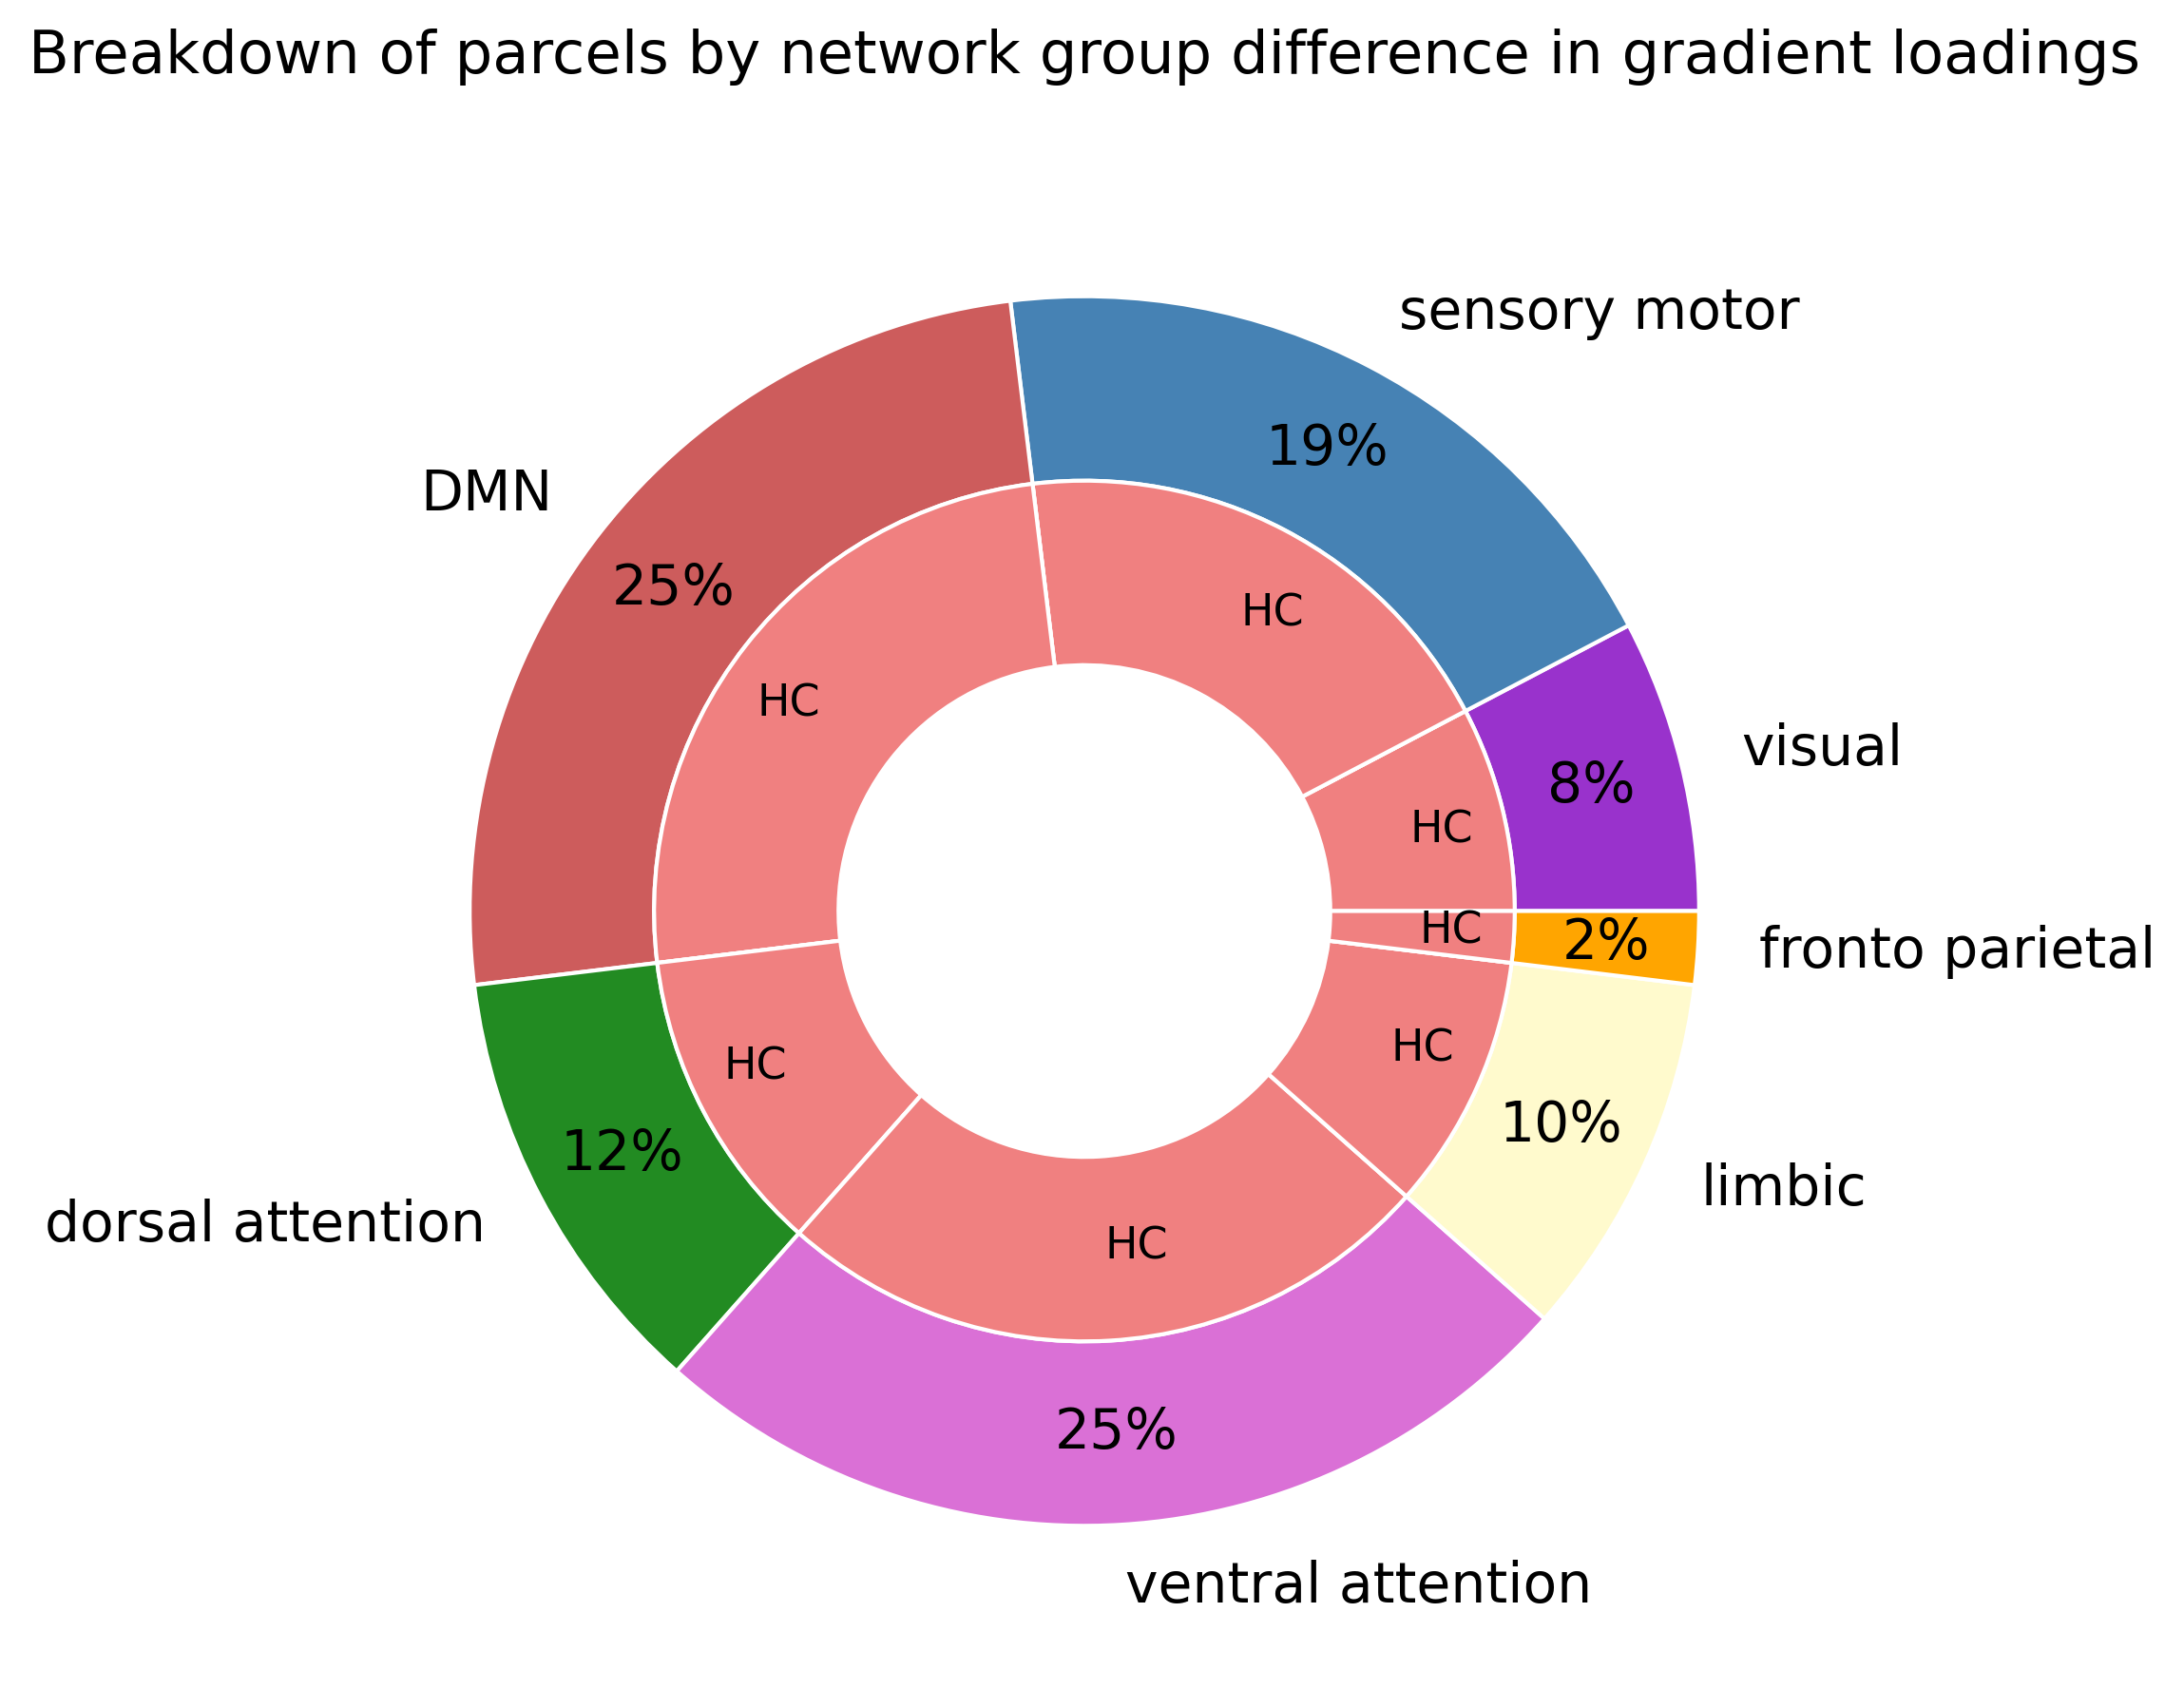

Number of significant parcels by sex:
visual - Sch: 0, HC: 4
sensory motor - Sch: 0, HC: 10
DMN - Sch: 0, HC: 13
dorsal attention - Sch: 0, HC: 6
ventral attention - Sch: 0, HC: 13
limbic - Sch: 0, HC: 5
fronto parietal - Sch: 0, HC: 1





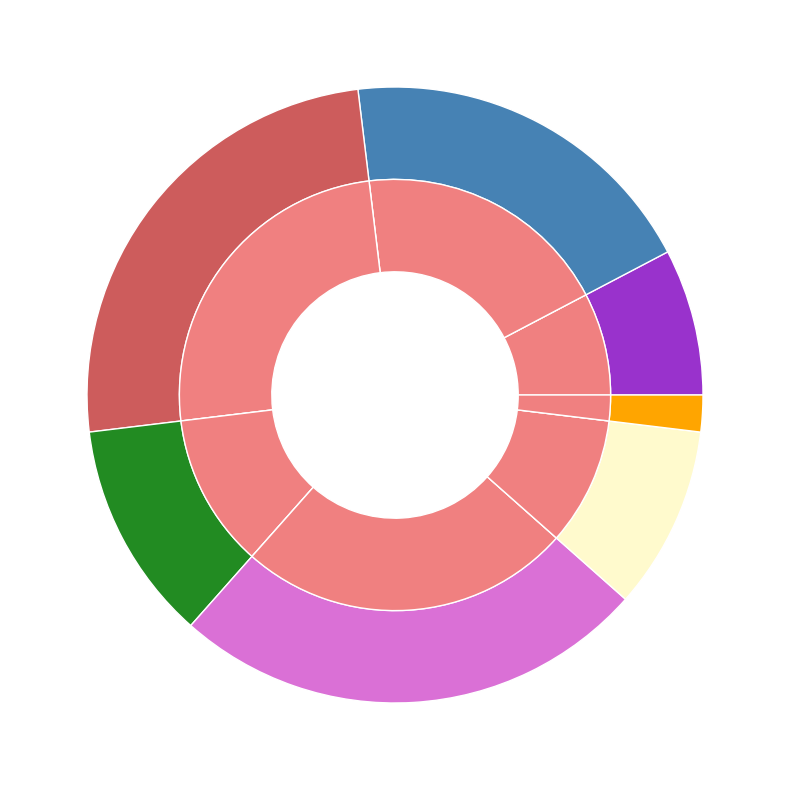

In [46]:
# GLM for Thickness
Thickness = pd.read_csv('/media/garlicseed/data2/Schizophrenia/morpho_train/combine_data/thick_avg_stack_SCHZ_HC.csv')
run_mixed_effects_analysis(Thickness, modality='MORPH', label='Thickness')

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.006	 R^2_adj: -0.006

Log-likelihood: -470.027 	 AIC: 950.053	 BIC: 969.079

Fixed effects:

已完成 0/400 个parcel的分析
Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.012	 R^2_adj: 0.000

Log-likelihood: -469.066 	 AIC: 948.131	 BIC: 967.157

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.029	 R^2_adj: 0.018

Log-likelihood: -466.127 	 AIC: 942.255	 BIC: 961.281

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: paramet

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.021	 R^2_adj: 0.009

Log-likelihood: -467.576 	 AIC: 945.153	 BIC: 964.179

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.021	 R^2_adj: 0.009

Log-likelihood: -467.513 	 AIC: 945.025	 BIC: 964.051

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.018	 R^2_adj: 0.006

Log-likelihood: -468.113 	 AIC: 946.226	 BIC: 965.252

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.057	 R^2_adj: 0.045

Log-likelihood: -461.370 	 AIC: 932.741	 BIC: 951.766

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.035	 R^2_adj: 0.023

Log-likelihood: -465.205 	 AIC: 940.410	 BIC: 959.435

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.042	 R^2_adj: 0.030

Log-likelihood: -464.030 	 AIC: 938.061	 BIC: 957.086

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.095	 R^2_adj: 0.084

Log-likelihood: -454.483 	 AIC: 918.967	 BIC: 937.992

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.014	 R^2_adj: 0.002

Log-likelihood: -468.672 	 AIC: 947.344	 BIC: 966.369

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.011	 R^2_adj: -0.001

Log-likelihood: -469.202 	 AIC: 948.404	 BIC: 967.429

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.037	 R^2_adj: 0.025

Log-likelihood: -464.784 	 AIC: 939.567	 BIC: 958.593

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.033	 R^2_adj: 0.021

Log-likelihood: -465.528 	 AIC: 941.056	 BIC: 960.082

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.021	 R^2_adj: 0.009

Log-likelihood: -467.635 	 AIC: 945.270	 BIC: 964.295

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.046	 R^2_adj: 0.035

Log-likelihood: -463.224 	 AIC: 936.448	 BIC: 955.474

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.039	 R^2_adj: 0.027

Log-likelihood: -464.494 	 AIC: 938.989	 BIC: 958.015

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.037	 R^2_adj: 0.025

Log-likelihood: -464.841 	 AIC: 939.682	 BIC: 958.708

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.002	 R^2_adj: -0.010

Log-likelihood: -470.688 	 AIC: 951.376	 BIC: 970.401

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.042	 R^2_adj: 0.030

Log-likelihood: -463.977 	 AIC: 937.954	 BIC: 956.979

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.048	 R^2_adj: 0.037

Log-likelihood: -462.854 	 AIC: 935.708	 BIC: 954.734

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.019	 R^2_adj: 0.007

Log-likelihood: -467.880 	 AIC: 945.761	 BIC: 964.786

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.011	 R^2_adj: -0.001

Log-likelihood: -469.243 	 AIC: 948.486	 BIC: 967.512

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.017	 R^2_adj: 0.005

Log-likelihood: -468.302 	 AIC: 946.604	 BIC: 965.630

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of obser

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.077	 R^2_adj: 0.066

Log-likelihood: -457.759 	 AIC: 925.517	 BIC: 944.543

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.034	 R^2_adj: 0.022

Log-likelihood: -465.342 	 AIC: 940.684	 BIC: 959.709

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.038	 R^2_adj: 0.026

Log-likelihood: -464.719 	 AIC: 939.439	 BIC: 958.464

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.030	 R^2_adj: 0.018

Log-likelihood: -466.015 	 AIC: 942.030	 BIC: 961.056

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.037	 R^2_adj: 0.025

Log-likelihood: -464.811 	 AIC: 939.623	 BIC: 958.648

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.015	 R^2_adj: 0.003

Log-likelihood: -468.519 	 AIC: 947.038	 BIC: 966.064

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observ

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.016	 R^2_adj: 0.004

Log-likelihood: -468.440 	 AIC: 946.880	 BIC: 965.906

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.008	 R^2_adj: -0.004

Log-likelihood: -469.672 	 AIC: 949.344	 BIC: 968.369

Fixed effects:

Formula: dependent_var~age+gender+diagnosis+study

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 332	 R^2: 0.003	 R^2_adj: -0.009

Log-likelihood: -470.511 	 AIC: 951.022	 BIC: 970.048

Fixed effects:



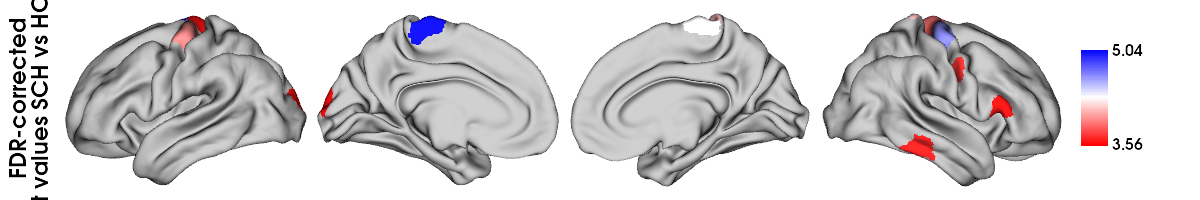

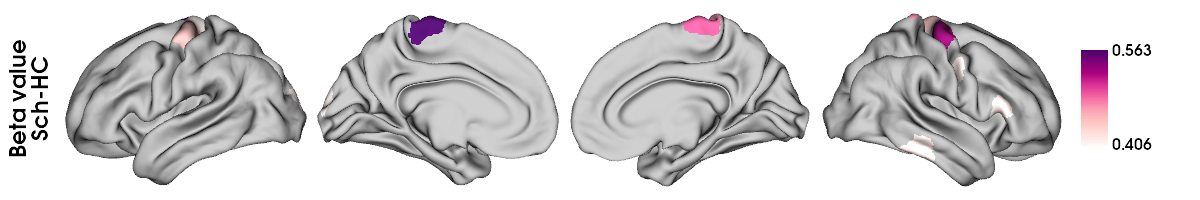

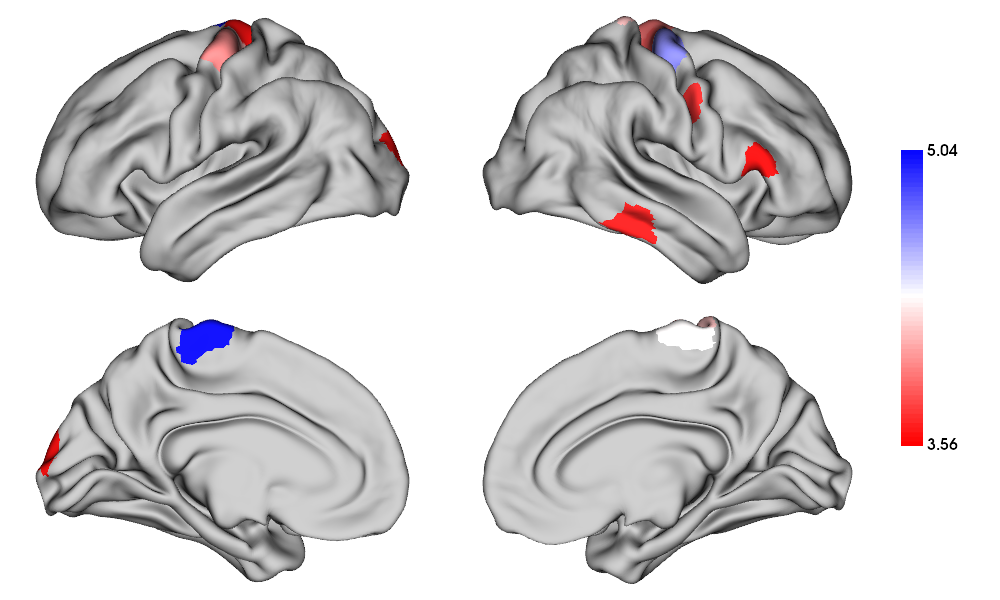

Number of significant parcels: 14

Number of significant parcels for sch: 14
Number of significant parcels for hc: 0

Number of significant parcels in each Yeo network (across group):
- visual: 1 out of 61 (1.64%) -> 7.14% of overall significance
- sensory motor: 11 out of 77 (14.29%) -> 78.57% of overall significance
- DMN: 1 out of 46 (2.17%) -> 7.14% of overall significance
- fronto parietal: 1 out of 91 (1.1%) -> 7.14% of overall significance





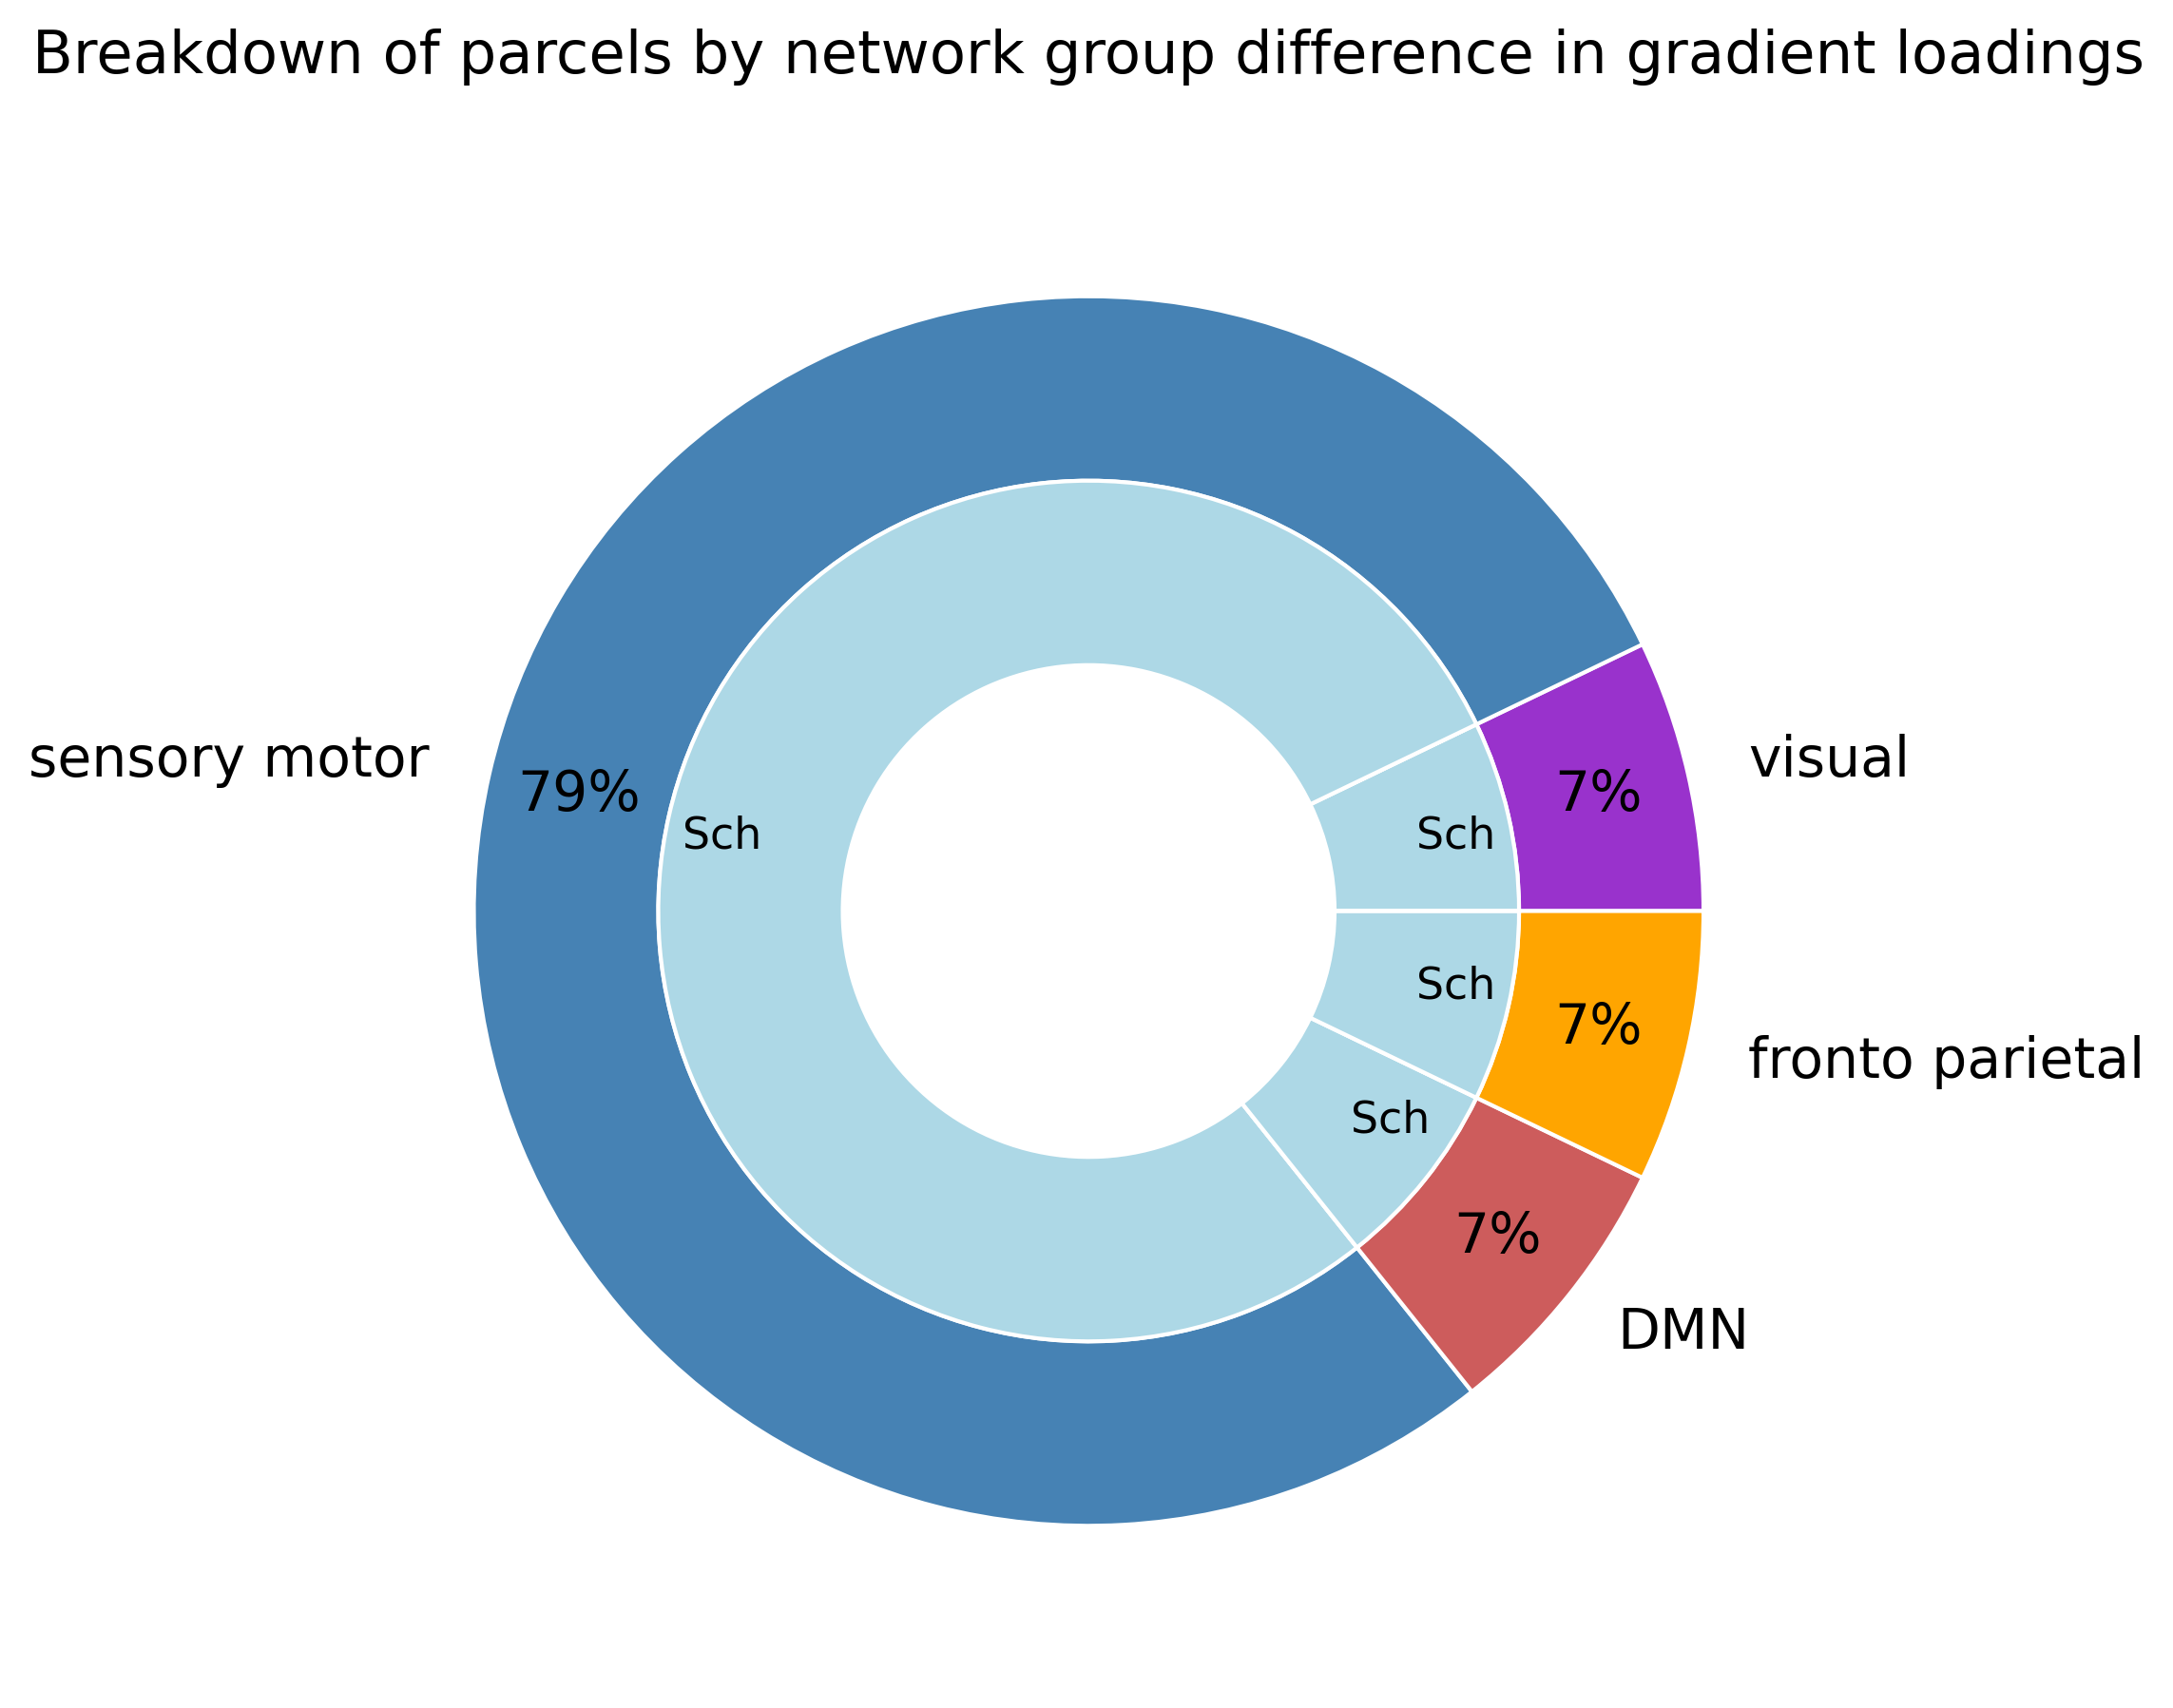

Number of significant parcels by sex:
visual - Sch: 1, HC: 0
sensory motor - Sch: 11, HC: 0
DMN - Sch: 1, HC: 0
dorsal attention - Sch: 0, HC: 0
ventral attention - Sch: 0, HC: 0
limbic - Sch: 0, HC: 0
fronto parietal - Sch: 1, HC: 0





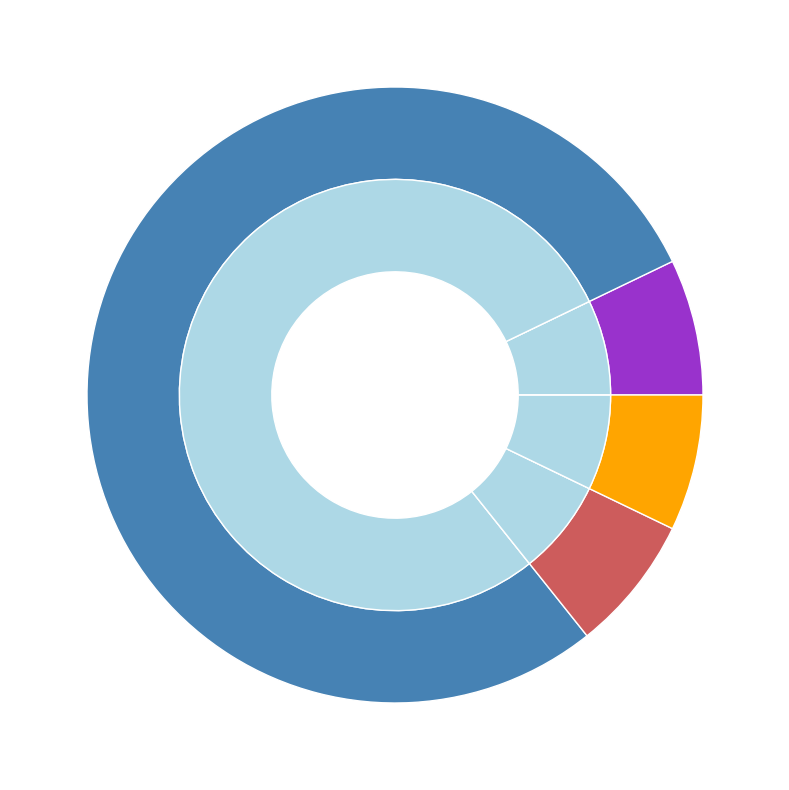

In [47]:
# GLM for Curvature
Curv = pd.read_csv('/media/garlicseed/data2/Schizophrenia/morpho_train/combine_data/mean_curv_stack_SCHZ_HC.csv')
run_mixed_effects_analysis(Curv, modality='MORPH', label='Gaussian_Curvature')